In [3]:
from pref_voting.dominance_axioms import condorcet_winner, condorcet_loser, pareto_dominance
from pref_voting.profiles import _find_updated_profile
from pref_voting.pairwise_profiles import *
from pref_voting.voting_methods import *
from pref_voting.generate_profiles import *
from pref_voting.voting_methods_registry import voting_methods
from pref_voting.generate_weighted_majority_graphs import *
from pref_voting.helper import *
from pref_voting.mappings import *  
from tqdm.notebook import tqdm
from itertools import permutations
from pref_voting.axioms import *

In [4]:
prof = ProfileWithTies([
    {0: 1, 2: 1, 1: 2, 3: 2}, 
    {3: 1, 0: 2, 1: 3, 2: 4}, 
    {2: 1, 1: 1, 3: 1}, 
    {3: 1, 0: 2, 1: 3, 2: 4}, 
    {1: 1, 2: 2}, 
    {}, 
    {3: 2, 1: 3, 2: 4}], 
    rcounts=[1, 1, 1, 1, 1, 1, 1], 
    cmap={0: 'a', 1: 'b', 2: 'c', 3: 'd'})

prof = ProfileWithTies([{}], rcounts=[100], cmap={0: 'a', 1: 'b', 2: 'c', 3: 'd'})
prof.display()

print(prof.to_latex())

+-----+
| 100 |
+-----+
+-----+



In [5]:
def to_quarto(prof, cmap = None, curr_cands = None):

    cmap = cmap if cmap is not None else prof.cmap
    rankings = prof._rankings if curr_cands is None else _find_updated_profile(prof._rankings, np.array([c for c in prof.candidates if c not in curr_cands]), len(prof.candidates))
    
    cs = 'c' * len(prof._rcounts)
    
    latex_str = "\\begin{array}{" + str(cs) + "}\n"
    latex_str += " & ".join([f"{rc}" for rc in prof._rcounts]) + "\\\\\hline \n"
    latex_str +=  "\\\\ \n".join([" & ".join([f"{cmap[c]}" for c in cs])  for cs in rankings.transpose()])
    latex_str += "\n\\end{array}"
    
    return latex_str


+---+---+---+---+---+---+
| 2 | 4 | 4 | 1 | 3 | 4 |
+---+---+---+---+---+---+
| d | a | d | d | c | c |
| c | c | b | a | b | a |
| b | b | a | c | a | d |
| a | d | c | b | d | b |
+---+---+---+---+---+---+


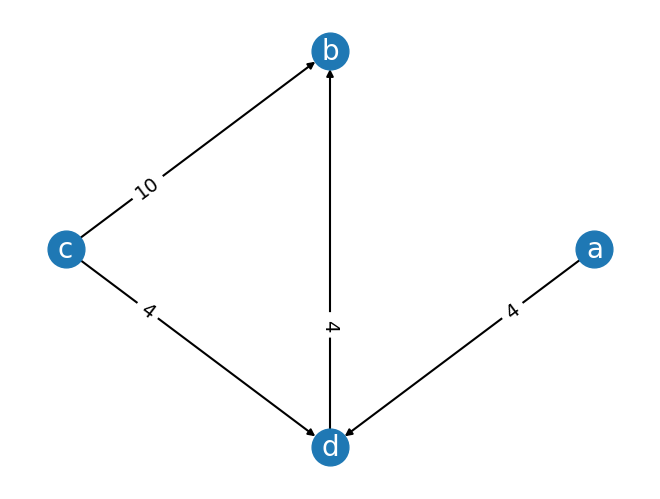

\begin{array}{cccccc}
2 & 4 & 4 & 1 & 3 & 4\\\hline 
d & a & d & d & c & c\\ 
c & c & b & a & b & a\\ 
b & b & a & c & a & d\\ 
a & d & c & b & d & b
\end{array}
* The margin of $a$ over $b$ is $9 - 9 = 0$
* The margin of $b$ over $a$ is $9 - 9 = 0$
* The margin of $a$ over $c$ is $9 - 9 = 0$
* The margin of $c$ over $a$ is $9 - 9 = 0$
* The margin of $a$ over $d$ is $11 - 7 = 4$
* The margin of $d$ over $a$ is $7 - 11 = -4$
* The margin of $b$ over $c$ is $4 - 14 = -10$
* The margin of $c$ over $b$ is $14 - 4 = 10$
* The margin of $b$ over $d$ is $7 - 11 = -4$
* The margin of $d$ over $b$ is $11 - 7 = 4$
* The margin of $c$ over $d$ is $11 - 7 = 4$
* The margin of $d$ over $c$ is $7 - 11 = -4$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1.5) (

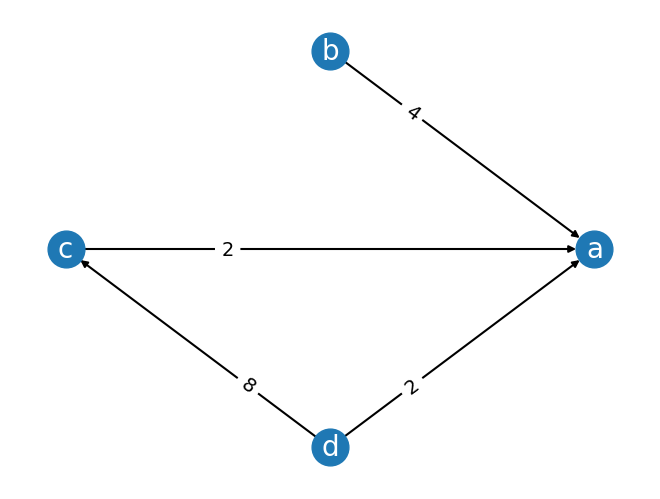

\begin{array}{cccc}
2 & 3 & 1 & 2\\\hline 
d & b & b & d\\ 
c & a & d & c\\ 
b & d & c & a\\ 
a & c & a & b
\end{array}
* The margin of $a$ over $b$ is $2 - 6 = -4$
* The margin of $b$ over $a$ is $6 - 2 = 4$
* The margin of $a$ over $c$ is $3 - 5 = -2$
* The margin of $c$ over $a$ is $5 - 3 = 2$
* The margin of $a$ over $d$ is $3 - 5 = -2$
* The margin of $d$ over $a$ is $5 - 3 = 2$
* The margin of $b$ over $c$ is $4 - 4 = 0$
* The margin of $c$ over $b$ is $4 - 4 = 0$
* The margin of $b$ over $d$ is $4 - 4 = 0$
* The margin of $d$ over $b$ is $4 - 4 = 0$
* The margin of $c$ over $d$ is $0 - 8 = -8$
* The margin of $d$ over $c$ is $8 - 0 = 8$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1.5) (d) {$d$};
\path[->,draw,thick] (b) to[pos=.7] node[f

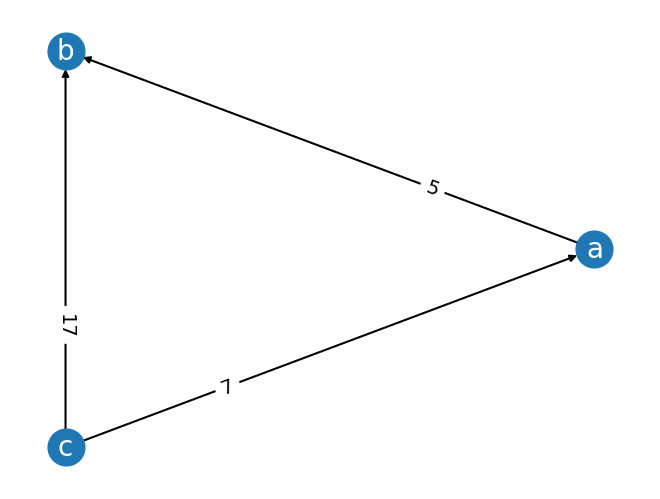

\begin{array}{cccc}
18 & 13 & 6 & 6\\\hline 
a & b & c & c\\ 
c & c & b & a\\ 
b & a & a & b
\end{array}
* The margin of $a$ over $b$ is $24 - 19 = 5$
* The margin of $b$ over $a$ is $19 - 24 = -5$
* The margin of $a$ over $c$ is $18 - 25 = -7$
* The margin of $c$ over $a$ is $25 - 18 = 7$
* The margin of $b$ over $c$ is $13 - 30 = -17$
* The margin of $c$ over $b$ is $30 - 13 = 17$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0) (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0) (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5) (b) {$b$};
\path[->,draw,thick] (a) to node[fill=white] {$5$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$17$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$7$} (a);
\end{tikzpicture}
+---+---+---+---+---+---+
| 4 | 1 | 6 | 1 | 3 | 1 |
+---+---+---+---+---+---+
| d | b | d | c | b | a |
| c | d | c | a | d | c |
| b | c | a | d | a | d |
| a | a | b | b | c | b |
+---+---+---+---

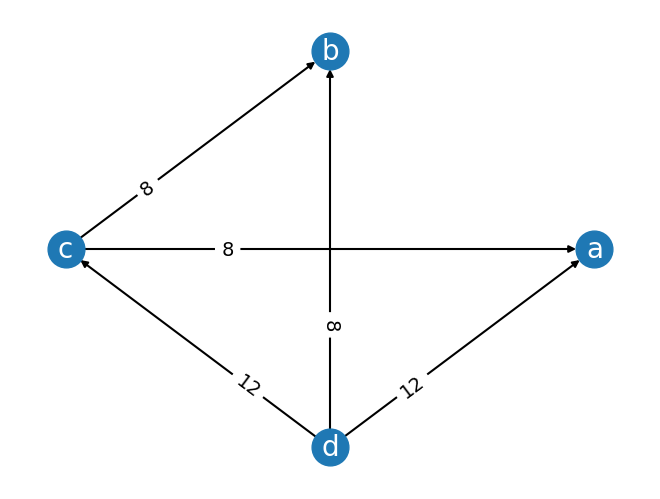

\begin{array}{cccccc}
4 & 1 & 6 & 1 & 3 & 1\\\hline 
d & b & d & c & b & a\\ 
c & d & c & a & d & c\\ 
b & c & a & d & a & d\\ 
a & a & b & b & c & b
\end{array}
* The margin of $a$ over $b$ is $8 - 8 = 0$
* The margin of $b$ over $a$ is $8 - 8 = 0$
* The margin of $a$ over $c$ is $4 - 12 = -8$
* The margin of $c$ over $a$ is $12 - 4 = 8$
* The margin of $a$ over $d$ is $2 - 14 = -12$
* The margin of $d$ over $a$ is $14 - 2 = 12$
* The margin of $b$ over $c$ is $4 - 12 = -8$
* The margin of $c$ over $b$ is $12 - 4 = 8$
* The margin of $b$ over $d$ is $4 - 12 = -8$
* The margin of $d$ over $b$ is $12 - 4 = 8$
* The margin of $c$ over $d$ is $2 - 14 = -12$
* The margin of $d$ over $c$ is $14 - 2 = 12$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1

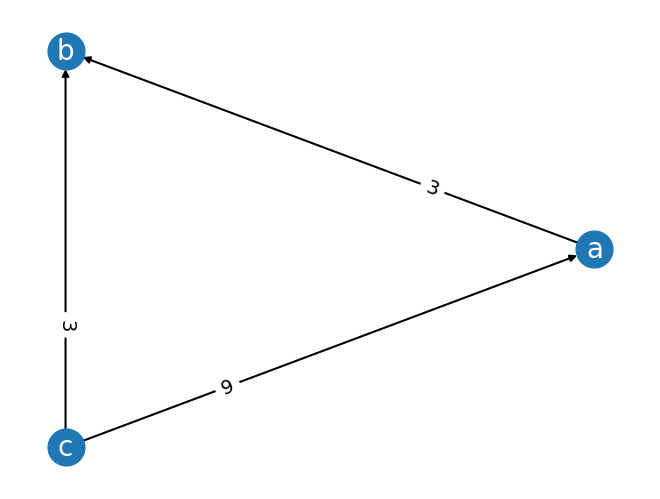

\begin{array}{ccccc}
9 & 12 & 8 & 6 & 8\\\hline 
a & b & c & c & a\\ 
c & c & b & a & b\\ 
b & a & a & b & c
\end{array}
* The margin of $a$ over $b$ is $23 - 20 = 3$
* The margin of $b$ over $a$ is $20 - 23 = -3$
* The margin of $a$ over $c$ is $17 - 26 = -9$
* The margin of $c$ over $a$ is $26 - 17 = 9$
* The margin of $b$ over $c$ is $20 - 23 = -3$
* The margin of $c$ over $b$ is $23 - 20 = 3$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0) (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0) (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5) (b) {$b$};
\path[->,draw,thick] (a) to node[fill=white] {$3$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$3$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$9$} (a);
\end{tikzpicture}
+---+----+---+----+
| 7 | 12 | 7 | 13 |
+---+----+---+----+
| a | b  | c | c  |
| c | c  | b | a  |
| b | a  | a | b  |
+---+----+---+----+


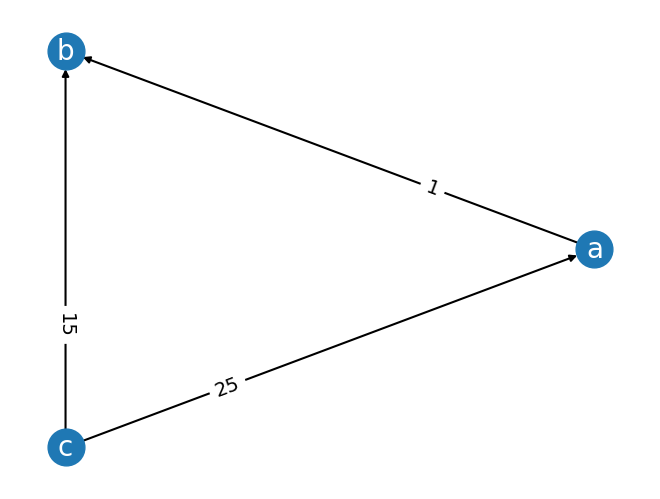

\begin{array}{cccc}
7 & 12 & 7 & 13\\\hline 
a & b & c & c\\ 
c & c & b & a\\ 
b & a & a & b
\end{array}
* The margin of $a$ over $b$ is $20 - 19 = 1$
* The margin of $b$ over $a$ is $19 - 20 = -1$
* The margin of $a$ over $c$ is $7 - 32 = -25$
* The margin of $c$ over $a$ is $32 - 7 = 25$
* The margin of $b$ over $c$ is $12 - 27 = -15$
* The margin of $c$ over $b$ is $27 - 12 = 15$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0) (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0) (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5) (b) {$b$};
\path[->,draw,thick] (a) to node[fill=white] {$1$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$15$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$25$} (a);
\end{tikzpicture}
+---+---+----+
| 7 | 8 | 10 |
+---+---+----+
| a | b | c  |
| c | c | b  |
| b | a | a  |
+---+---+----+


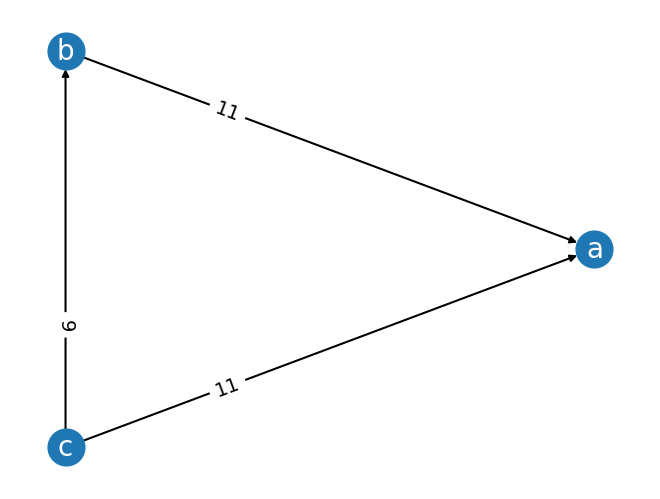

\begin{array}{ccc}
7 & 8 & 10\\\hline 
a & b & c\\ 
c & c & b\\ 
b & a & a
\end{array}
* The margin of $a$ over $b$ is $7 - 18 = -11$
* The margin of $b$ over $a$ is $18 - 7 = 11$
* The margin of $a$ over $c$ is $7 - 18 = -11$
* The margin of $c$ over $a$ is $18 - 7 = 11$
* The margin of $b$ over $c$ is $8 - 17 = -9$
* The margin of $c$ over $b$ is $17 - 8 = 9$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0) (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0) (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5) (b) {$b$};
\path[->,draw,thick] (b) to node[fill=white] {$11$} (a);
\path[->,draw,thick] (c) to node[fill=white] {$9$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$11$} (a);
\end{tikzpicture}
+---+---+---+---+
| 3 | 3 | 5 | 3 |
+---+---+---+---+
| d | b | b | d |
| c | a | d | c |
| b | d | c | a |
| a | c | a | b |
+---+---+---+---+


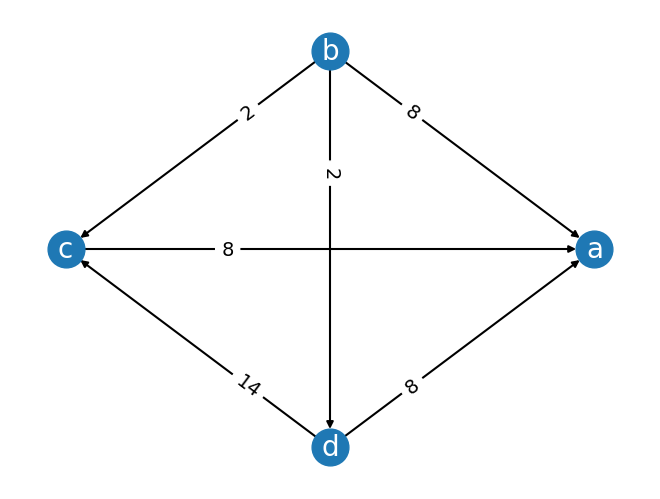

\begin{array}{cccc}
3 & 3 & 5 & 3\\\hline 
d & b & b & d\\ 
c & a & d & c\\ 
b & d & c & a\\ 
a & c & a & b
\end{array}
* The margin of $a$ over $b$ is $3 - 11 = -8$
* The margin of $b$ over $a$ is $11 - 3 = 8$
* The margin of $a$ over $c$ is $3 - 11 = -8$
* The margin of $c$ over $a$ is $11 - 3 = 8$
* The margin of $a$ over $d$ is $3 - 11 = -8$
* The margin of $d$ over $a$ is $11 - 3 = 8$
* The margin of $b$ over $c$ is $8 - 6 = 2$
* The margin of $c$ over $b$ is $6 - 8 = -2$
* The margin of $b$ over $d$ is $8 - 6 = 2$
* The margin of $d$ over $b$ is $6 - 8 = -2$
* The margin of $c$ over $d$ is $0 - 14 = -14$
* The margin of $d$ over $c$ is $14 - 0 = 14$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1.5) (d) {$d$};
\path[->,draw,thick] (b) to[po

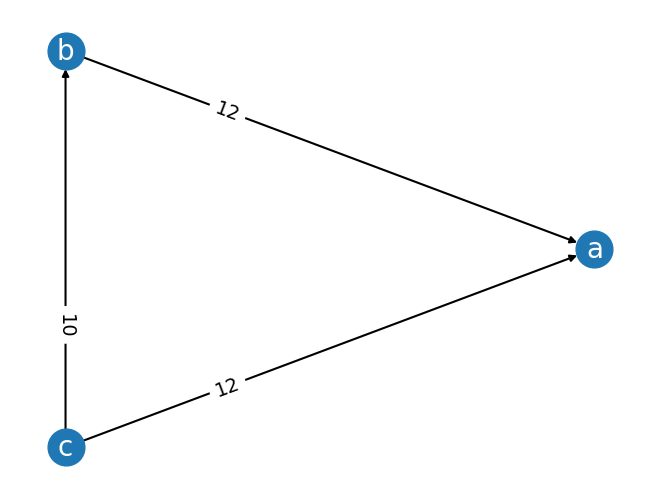

\begin{array}{ccc}
9 & 10 & 11\\\hline 
a & b & c\\ 
c & c & b\\ 
b & a & a
\end{array}
* The margin of $a$ over $b$ is $9 - 21 = -12$
* The margin of $b$ over $a$ is $21 - 9 = 12$
* The margin of $a$ over $c$ is $9 - 21 = -12$
* The margin of $c$ over $a$ is $21 - 9 = 12$
* The margin of $b$ over $c$ is $10 - 20 = -10$
* The margin of $c$ over $b$ is $20 - 10 = 10$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0) (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0) (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5) (b) {$b$};
\path[->,draw,thick] (b) to node[fill=white] {$12$} (a);
\path[->,draw,thick] (c) to node[fill=white] {$10$} (b);
\path[->,draw,thick] (c) to node[fill=white] {$12$} (a);
\end{tikzpicture}
+---+---+---+---+---+---+
| 5 | 3 | 3 | 2 | 1 | 5 |
+---+---+---+---+---+---+
| b | b | c | b | a | c |
| a | d | b | d | c | d |
| d | c | a | a | d | b |
| c | a | d | c | b | a |
+---+---+---+---+---+---+


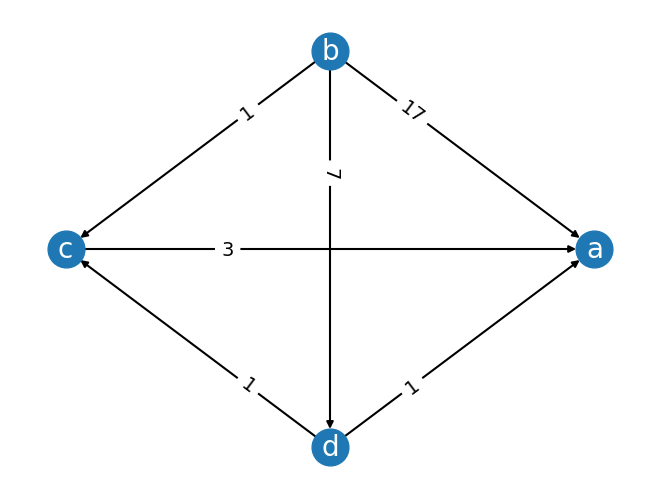

\begin{array}{cccccc}
5 & 3 & 3 & 2 & 1 & 5\\\hline 
b & b & c & b & a & c\\ 
a & d & b & d & c & d\\ 
d & c & a & a & d & b\\ 
c & a & d & c & b & a
\end{array}
* The margin of $a$ over $b$ is $1 - 18 = -17$
* The margin of $b$ over $a$ is $18 - 1 = 17$
* The margin of $a$ over $c$ is $8 - 11 = -3$
* The margin of $c$ over $a$ is $11 - 8 = 3$
* The margin of $a$ over $d$ is $9 - 10 = -1$
* The margin of $d$ over $a$ is $10 - 9 = 1$
* The margin of $b$ over $c$ is $10 - 9 = 1$
* The margin of $c$ over $b$ is $9 - 10 = -1$
* The margin of $b$ over $d$ is $13 - 6 = 7$
* The margin of $d$ over $b$ is $6 - 13 = -7$
* The margin of $c$ over $d$ is $9 - 10 = -1$
* The margin of $d$ over $c$ is $10 - 9 = 1$

The margin graph is:

\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-

In [6]:
from itertools import combinations

for t in range(10): 

    num_cands = random.choice([3, 4, 4, 4])

    prof = generate_profile(num_cands, 50)

    cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}

    num_rankings = random.choice([3, 4, 5, 6])
    prof_smaller = Profile(prof.anonymize().ranking_types[0:num_rankings], list(prof.anonymize()._rcounts)[0:num_rankings], cmap=cmap)

    prof_smaller.display()

    prof_smaller.display_margin_graph()
    print(to_quarto(prof_smaller, cmap=cmap))

    for c1, c2 in combinations(prof_smaller.candidates, 2):
        print(f"* The margin of ${cmap[c1]}$ over ${cmap[c2]}$ is ${prof_smaller.support(c1, c2)} - {prof_smaller.support(c2, c1)} = {prof_smaller.margin(c1, c2)}$")
        print(f"* The margin of ${cmap[c2]}$ over ${cmap[c1]}$ is ${prof_smaller.support(c2, c1)} - {prof_smaller.support(c1, c2)} = {prof_smaller.margin(c2, c1)}$")

    print("\nThe margin graph is:")
    print(prof_smaller.margin_graph().to_latex(cmap=cmap))

print("\n\n--------\n\n")

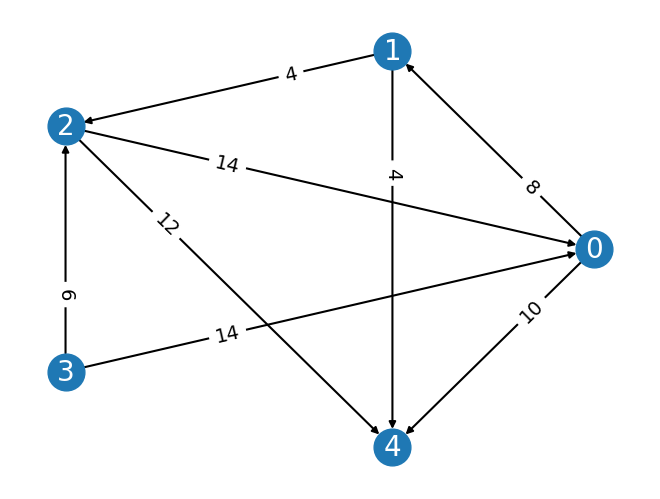

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 4 | 4 | 5 | 5 | 2 | 2 | 2 | 2 | 7 | 7 | 6 | 6 | 7 | 7 | 3 | 3 |
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| 0 | 4 | 0 | 3 | 1 | 4 | 1 | 3 | 2 | 4 | 2 | 3 | 3 | 4 | 3 | 4 |
| 1 | 3 | 4 | 2 | 2 | 3 | 4 | 2 | 0 | 3 | 4 | 1 | 0 | 2 | 2 | 1 |
| 2 | 2 | 1 | 1 | 0 | 0 | 0 | 0 | 1 | 1 | 0 | 0 | 1 | 1 | 0 | 0 |
| 3 | 0 | 2 | 0 | 3 | 1 | 2 | 1 | 3 | 2 | 1 | 2 | 2 | 3 | 1 | 3 |
| 4 | 1 | 3 | 4 | 4 | 2 | 3 | 4 | 4 | 0 | 3 | 4 | 4 | 0 | 4 | 2 |
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
+---+---+---+---+---+---+---+---+---+---+
| 1 | 2 | 1 | 1 | 4 | 2 | 5 | 1 | 4 | 5 |
+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 2 | 2 | 2 | 3 | 3 | 3 | 4 |
| 2 | 2 | 4 | 0 | 0 | 4 | 0 | 0 | 2 | 1 |
| 0 | 3 | 3 | 3 | 4 | 3 | 1 | 1 | 0 | 3 |
| 4 | 0 | 2 | 1 | 1 | 0 | 2 | 4 | 1 | 2 |
| 3 | 4 | 0 | 4 | 3 | 1 | 4 | 2 | 4 | 0 |
+---+---+---+---+---+---+---+---+---+---+


In [7]:
mg = generate_margin_graph(5)
mg.display()
mg.debord_profile().display()
mg.minimal_profile().display()

In [8]:
num_cands = 4
num_voters = 5
a=0
b=1
c=2
d=3
e=4
cmap = {a: 'a', b: 'b', c: 'c', d: 'd', e: 'e'}

num_trials = 1000000

for t in range(num_trials): 
    prof = generate_profile(num_cands, num_voters)
    rankings = prof.rankings

    if len(rankings) == 5:
        v1_ranking = rankings[0]
        borda_ws = borda(prof)
        if len(borda_ws) == 2 and  v1_ranking[0] in borda_ws and v1_ranking[3] in borda_ws:

            margins = list(set([prof.margin(c1, c2) for c1 in prof.candidates for c2 in prof.candidates if prof.majority_prefers(c1, c2)]))

            if len(margins) >= 3: 
                for new_ranking in permutations(prof.candidates):
                    new_prof = Profile([new_ranking] + rankings[1:])
                    new_borda_ws = borda(new_prof)
                    if (len(new_borda_ws)==2 and v1_ranking[1] in new_borda_ws and v1_ranking[2] in new_borda_ws) or (len(new_borda_ws)==1 and v1_ranking[1] in new_borda_ws):
                        print(margins)
                        print(prof)
                        print(prof.to_latex(cmap=cmap))
                        print(new_ranking)
                        print(new_prof.to_latex(cmap=cmap))
                        break


In [75]:
num_cands = 5
num_voters = 4

a=0
b=1
c=2
d=3
e=4
cmap = {a: 'a', b: 'b', c: 'c', d: 'd', e: 'e'}


for _prof in enumerate_anon_profile(num_cands, num_voters):
    prof = _prof.anonymize()
    rankings = prof.rankings

    if True or len(rankings) == 5:
        v1_ranking = rankings[0]
        borda_ws = borda(prof)
        if len(borda_ws) == 2 and  v1_ranking[0] in borda_ws and v1_ranking[4] in borda_ws:
        # if len(borda_ws) == 1 and  v1_ranking[1] in borda_ws:

            margins = list(set([prof.margin(c1, c2) for c1 in prof.candidates for c2 in prof.candidates if prof.majority_prefers(c1, c2)]))

            if len(margins) >= 2: 
                found_it = False
                for new_ranking in permutations(prof.candidates):
                    new_prof = Profile([new_ranking] + rankings[1:])
                    new_borda_ws = borda(new_prof)
                    # if (len(new_borda_ws)==2 and v1_ranking[1] in new_borda_ws and v1_ranking[2] in new_borda_ws):
                    if (len(new_borda_ws)==2 and v1_ranking[1] in new_borda_ws and v1_ranking[2] in new_borda_ws) or (len(new_borda_ws)==2 and v1_ranking[2] in new_borda_ws and v1_ranking[3] in new_borda_ws):
                    # if (len(new_borda_ws)==2 and v1_ranking[0] in new_borda_ws and v1_ranking[2] in new_borda_ws) or (len(new_borda_ws)==2 and v1_ranking[0] in new_borda_ws and v1_ranking[3] in new_borda_ws):
                        print(margins)
                        print(prof)
                        print(borda_ws)
                        print(prof.to_latex(cmap=cmap))
                        print(new_ranking)
                        print(new_borda_ws)
                        print(new_prof.to_latex(cmap=cmap))
                        found_it = False
                        break
            if found_it:
                break

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| c | c | c | d | d |
| b | b | b | b | b |
| a | d | d | a | a |
| d | a | a | c | c |
+---+---+---+---+---+


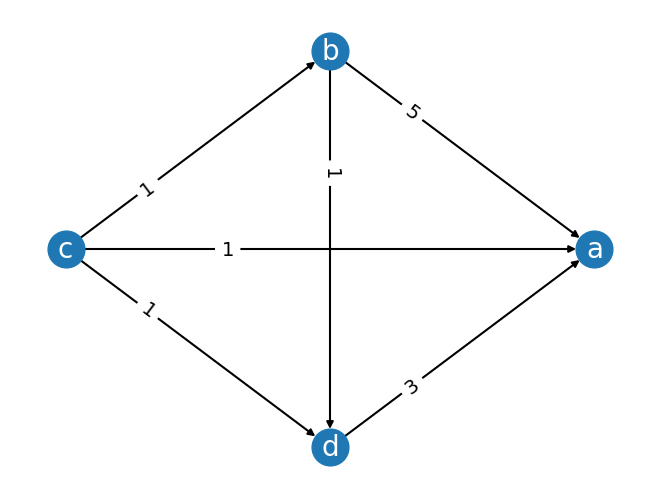


\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1.5) (d) {$d$};
\path[->,draw,thick] (b) to[pos=.7] node[fill=white] {$5$} (a);
\path[->,draw,thick] (c) to node[fill=white] {$1$} (a);
\path[->,draw,thick] (d) to node[fill=white] {$3$} (a);
\path[->,draw,thick] (c) to node[fill=white] {$1$} (b);
\path[->,draw,thick] (b) to node[fill=white] {$1$} (d);
\path[->,draw,thick] (c) to[pos=.7]  node[fill=white] {$1$} (d);
\end{tikzpicture}


In [77]:
a=0
b=1
c=2
d=3
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'}
orig_prof = Profile([
    [c, b, a, d], 
    [c, b, d, a], 
    [c, b, d, a], 
    [d, b, a, c],
    [d, b, a, c],
], cmap=cmap)
orig_prof.display()
    
mg = orig_prof.margin_graph()
mg.display()
print(mg.to_latex())

In [93]:
a=0
b=1
c=2
d=3
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'}
orig_prof = Profile([
    [c, b, a, d], 
    [c, b, d, a], 
    [c, b, d, a], 
    [d, b, a, c],
    [d, b, a, c],
], cmap=cmap)
orig_prof.display()

borda_ws = borda(orig_prof)
print(borda_ws)

for t in range(20): 
    _prof = generate_profile(4, 5)
    rankings = list(_prof.rankings)  
    if len(rankings) == 5: 
        prof = Profile([
            [c, b, a, d]
        ] + rankings[1:], cmap=cmap)
        new_borda_ws = borda(prof)
        if borda_ws == new_borda_ws:
            print('Match')
            print(prof)
            print(prof.to_latex())  

            print("\n--------\n")

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| c | c | c | d | d |
| b | b | b | b | b |
| a | d | d | a | a |
| d | a | a | c | c |
+---+---+---+---+---+
[1]
Match
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| c | d | b | b | a |
| b | b | a | d | d |
| a | a | d | a | c |
| d | c | c | c | b |
+---+---+---+---+---+
\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $b$ & $b$ & $a$\\ 
$b$ & $b$ & $a$ & $d$ & $d$\\ 
$a$ & $a$ & $d$ & $a$ & $c$\\ 
$d$ & $c$ & $c$ & $c$ & $b$
\end{tabular}

--------

Match
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| c | b | b | d | b |
| b | a | c | a | d |
| a | c | a | c | c |
| d | d | d | b | a |
+---+---+---+---+---+
\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $b$ & $b$ & $d$ & $b$\\ 
$b$ & $a$ & $c$ & $a$ & $d$\\ 
$a$ & $c$ & $a$ & $c$ & $c$\\ 
$d$ & $d$ & $d$ & $b$ & $a$
\end{tabular}

--------

Match
+---+---+---+---+---+
| 1 | 1 | 1 | 1 

Match


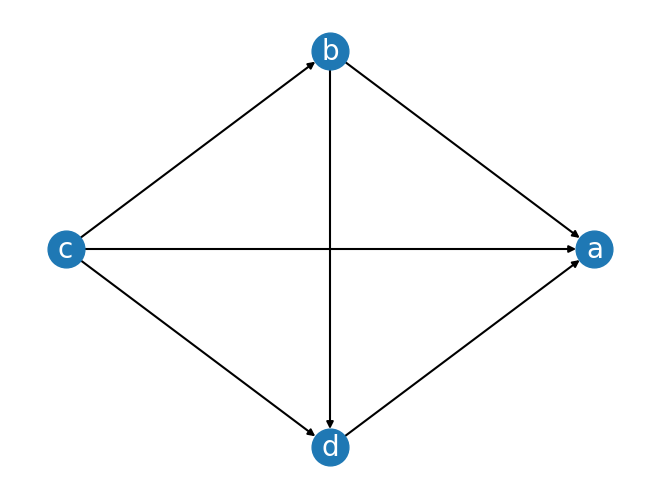

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $b$ & $c$ & $a$ & $b$\\ 
$b$ & $c$ & $b$ & $c$ & $d$\\ 
$a$ & $d$ & $d$ & $b$ & $c$\\ 
$d$ & $a$ & $a$ & $d$ & $a$
\end{tabular}

-------

Match


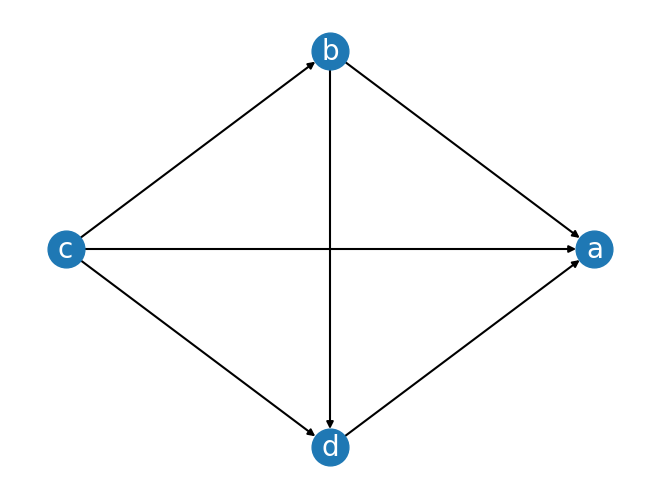

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $c$ & $b$ & $c$\\ 
$b$ & $a$ & $b$ & $d$ & $a$\\ 
$a$ & $b$ & $d$ & $a$ & $b$\\ 
$d$ & $c$ & $a$ & $c$ & $d$
\end{tabular}

-------

Match


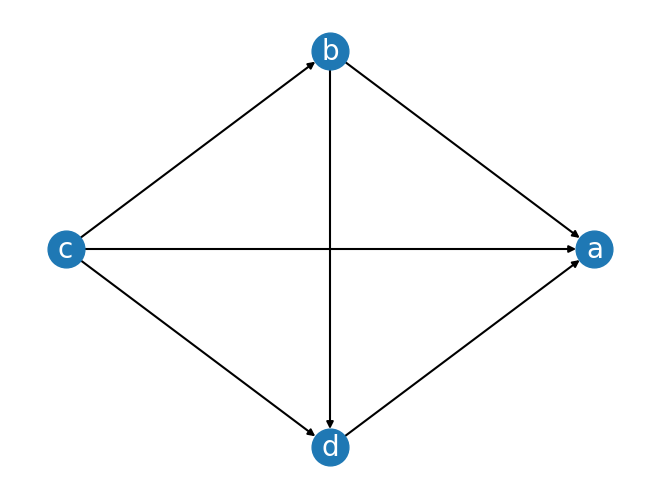

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $c$ & $d$ & $b$ & $c$\\ 
$b$ & $b$ & $a$ & $c$ & $b$\\ 
$a$ & $d$ & $c$ & $d$ & $a$\\ 
$d$ & $a$ & $b$ & $a$ & $d$
\end{tabular}

-------

Match


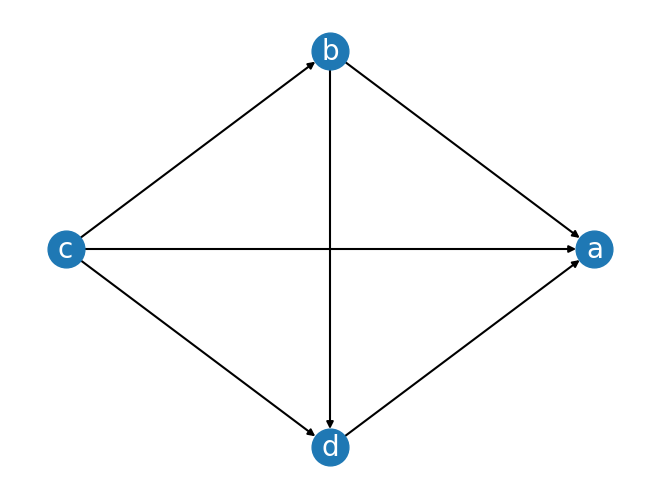

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $c$ & $c$ & $b$\\ 
$b$ & $b$ & $b$ & $a$ & $d$\\ 
$a$ & $a$ & $d$ & $d$ & $a$\\ 
$d$ & $c$ & $a$ & $b$ & $c$
\end{tabular}

-------

Match


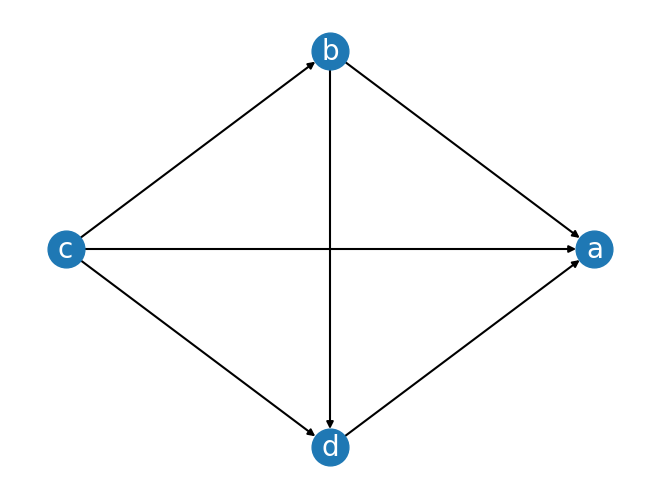

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $d$ & $b$ & $b$\\ 
$b$ & $c$ & $c$ & $c$ & $c$\\ 
$a$ & $b$ & $b$ & $a$ & $d$\\ 
$d$ & $a$ & $a$ & $d$ & $a$
\end{tabular}

-------

Match


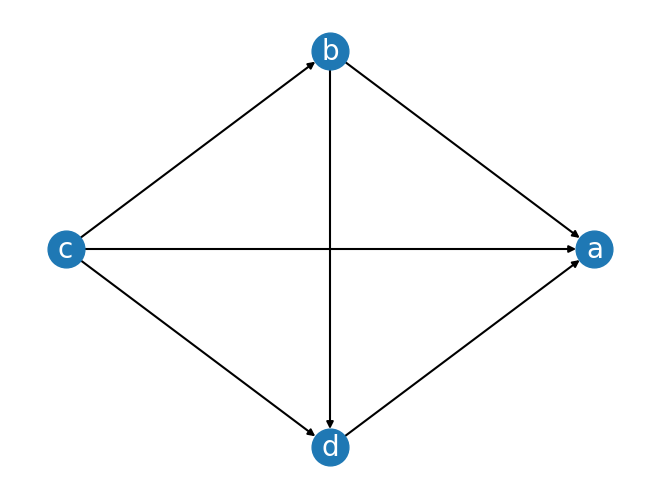

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $b$ & $c$ & $c$\\ 
$b$ & $a$ & $d$ & $d$ & $b$\\ 
$a$ & $b$ & $c$ & $b$ & $a$\\ 
$d$ & $c$ & $a$ & $a$ & $d$
\end{tabular}

-------



In [85]:
for t in range(100): 
    _prof = generate_profile(4, 5)
    rankings = list(_prof.rankings)  
    if len(rankings) == 5: 
        prof = Profile([
            [c, b, a, d]
        ] + rankings[1:], cmap=cmap)
        maj_g = prof.majority_graph()
        orig_maj_g = orig_prof.majority_graph()
        if maj_g == orig_maj_g:
            print('Match')
            maj_g.display()
            print(prof.to_latex())  
            print("\n-------\n")

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $b$ & $b$ & $b$\\ 
$b$ & $b$ & $c$ & $d$ & $c$\\ 
$a$ & $a$ & $a$ & $a$ & $a$\\ 
$d$ & $c$ & $d$ & $c$ & $d$
\end{tabular}
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| c | d | b | b | b |
| b | b | c | d | c |
| a | a | a | a | a |
| d | c | d | c | d |
+---+---+---+---+---+


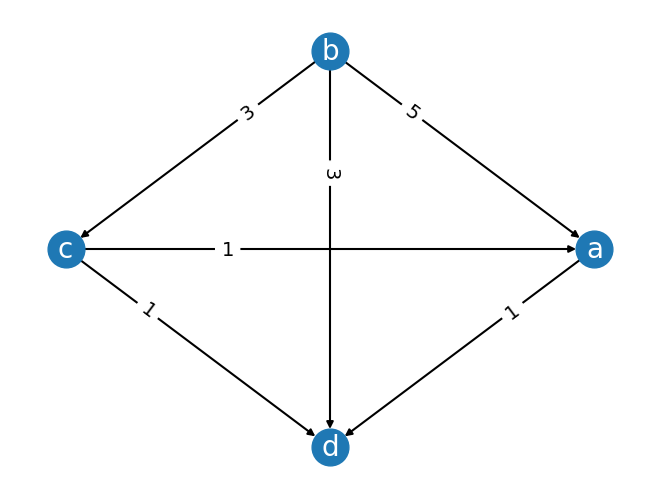


\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1.5) (d) {$d$};
\path[->,draw,thick] (b) to[pos=.7] node[fill=white] {$5$} (a);
\path[->,draw,thick] (c) to node[fill=white] {$1$} (a);
\path[->,draw,thick] (a) to node[fill=white] {$1$} (d);
\path[->,draw,thick] (b) to node[fill=white] {$3$} (c);
\path[->,draw,thick] (b) to node[fill=white] {$3$} (d);
\path[->,draw,thick] (c) to[pos=.7]  node[fill=white] {$1$} (d);
\end{tikzpicture}


In [32]:
a=0
b=1
c=2
d=3
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'}
orig_prof = Profile([
    [c, b, a, d], 
    [d, b, a, c], 
    [b, c, a, d],
    [b, d, a, c],
    [b, c, a, d]
], cmap=cmap)

print(orig_prof.to_latex())
orig_prof.display()
    
mg = orig_prof.margin_graph()
mg.display()
print(mg.to_latex())

Match


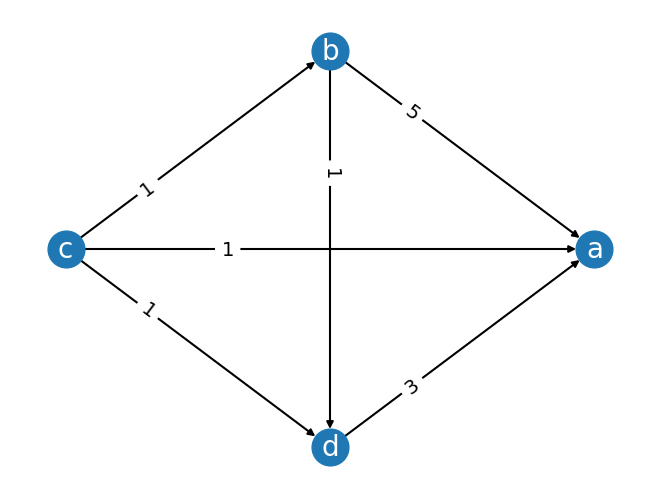

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $c$ & $c$ & $d$\\ 
$b$ & $b$ & $b$ & $b$ & $b$\\ 
$a$ & $a$ & $d$ & $d$ & $a$\\ 
$d$ & $c$ & $a$ & $a$ & $c$
\end{tabular}

----------

Match


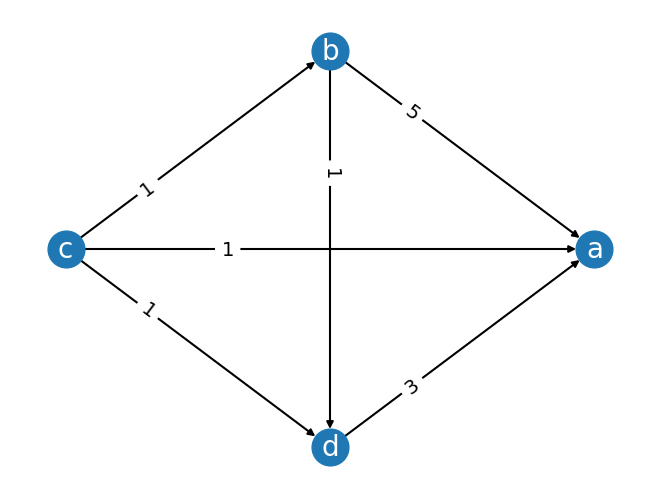

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $c$ & $d$ & $c$ & $b$\\ 
$b$ & $d$ & $b$ & $b$ & $d$\\ 
$a$ & $b$ & $a$ & $d$ & $a$\\ 
$d$ & $a$ & $c$ & $a$ & $c$
\end{tabular}

----------

Match


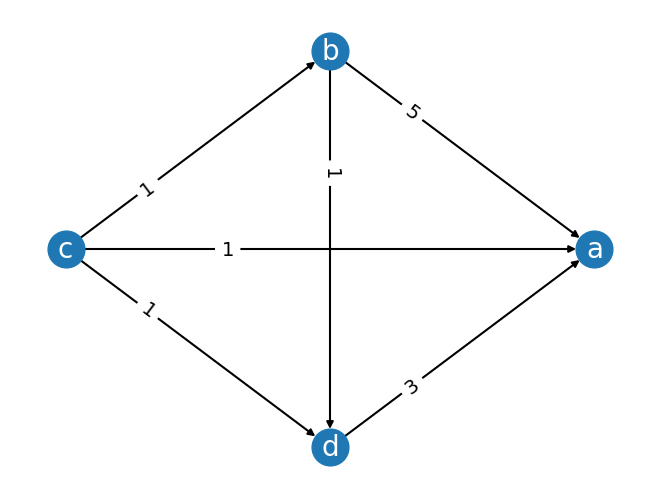

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $d$ & $c$ & $b$ & $c$\\ 
$b$ & $b$ & $d$ & $d$ & $b$\\ 
$a$ & $a$ & $b$ & $a$ & $d$\\ 
$d$ & $c$ & $a$ & $c$ & $a$
\end{tabular}

----------

Match


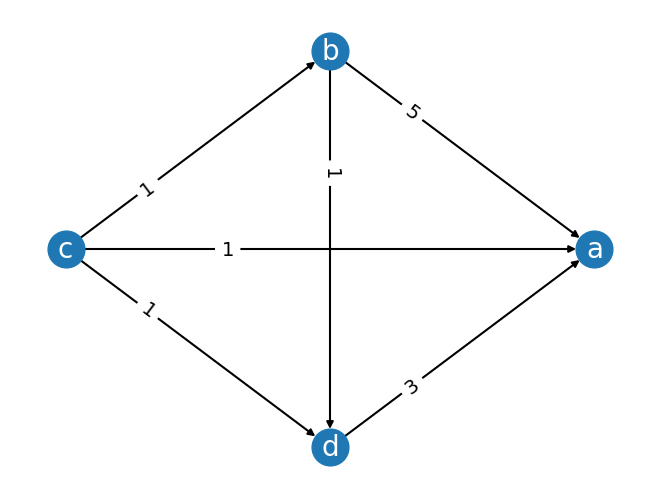

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $c$ & $d$ & $c$ & $b$\\ 
$b$ & $d$ & $b$ & $b$ & $d$\\ 
$a$ & $b$ & $a$ & $d$ & $a$\\ 
$d$ & $a$ & $c$ & $a$ & $c$
\end{tabular}

----------

Match


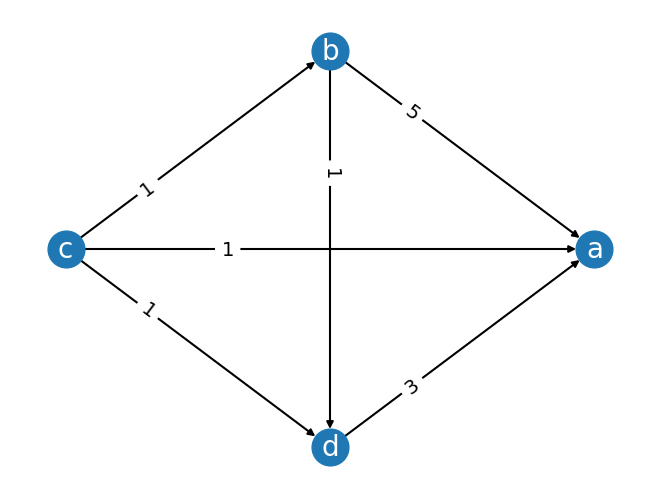

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $b$ & $c$ & $c$ & $b$\\ 
$b$ & $d$ & $d$ & $d$ & $d$\\ 
$a$ & $a$ & $b$ & $b$ & $a$\\ 
$d$ & $c$ & $a$ & $a$ & $c$
\end{tabular}

----------

Match


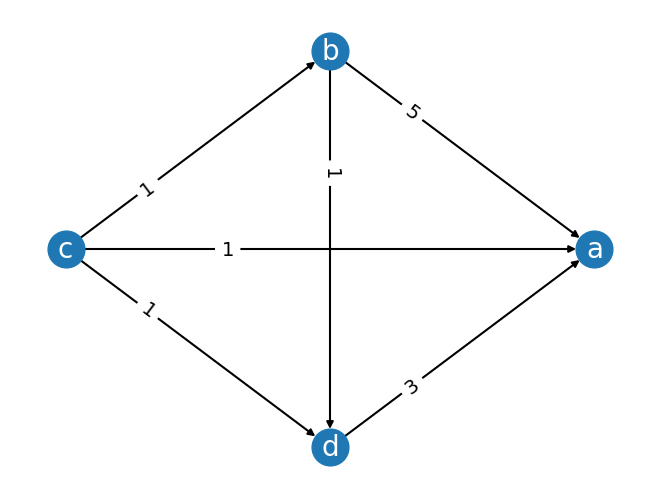

\begin{tabular}{ccccc}
$1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $c$ & $b$ & $d$ & $c$\\ 
$b$ & $d$ & $d$ & $b$ & $b$\\ 
$a$ & $b$ & $a$ & $a$ & $d$\\ 
$d$ & $a$ & $c$ & $c$ & $a$
\end{tabular}

----------



In [91]:
for t in range(100000): 
    _prof = generate_profile(4, 5)
    rankings = list(_prof.rankings)  
    if True or len(rankings) == 5: 
        prof = Profile([
            [c, b, a, d]
        ] + rankings[1:], cmap=cmap)
        mg = prof.margin_graph()
        orig_maj_g = orig_prof.margin_graph()
        if mg == orig_maj_g:
            print('Match')
            mg.display()
            print(prof.to_latex())  

            print("\n----------\n")

In [2]:
import pickle

In [3]:
def _revealed_weak_preference(c1, c2, menu, choice): 
    """Returns the revealed weak preference of a menu of choices. 
    """

    return c1 in menu and c2 in menu and c1 in choice

def _revealed_strict_preference(c1, c2, menu, choice): 
    """Returns the revealed strict preference of a menu of choices. 

    """

    return _revealed_weak_preference(c1, c2, menu, choice) and not _revealed_weak_preference(c2, c1, menu, choice)

def _revealed_indifference(c1, c2, menu, choice): 
    """Returns the revealed indifference of a menu of choices. 

    """

    return _revealed_weak_preference(c1, c2, menu, choice) and  _revealed_weak_preference(c2, c1, menu, choice)

print( {1, 2}, {1, 2})
print(_revealed_weak_preference(1, 2, {1, 2}, {1, 2}))
print(_revealed_weak_preference(2, 1, {1, 2}, {1, 2}))

print(_revealed_strict_preference(1, 2, {1, 2}, {1, 2}))
print(_revealed_strict_preference(2, 1, {1, 2}, {1, 2}))
print(_revealed_indifference(1, 2, {1, 2}, {1, 2}))
print(_revealed_indifference(2, 1, {1, 2}, {1, 2}))

print( {1, 2}, {1})
print(_revealed_weak_preference(1, 2, {1, 2}, {1}))
print(_revealed_weak_preference(2, 1, {1, 2}, {1}))
print(_revealed_strict_preference(1, 2, {1, 2}, {1}))
print(_revealed_strict_preference(2, 1, {1, 2}, {1}))
print(_revealed_indifference(1, 2, {1, 2}, {1}))
print(_revealed_indifference(2, 1, {1, 2}, {1}))



{1, 2} {1, 2}
True
True
False
False
True
True
{1, 2} {1}
True
False
True
False
False
False


3: {A, B} -> {A}, {A, C} -> {C}, {B, C} -> {B}
2: {A, B} -> {B}, {A, C} -> {A}, {B, C} -> {C}


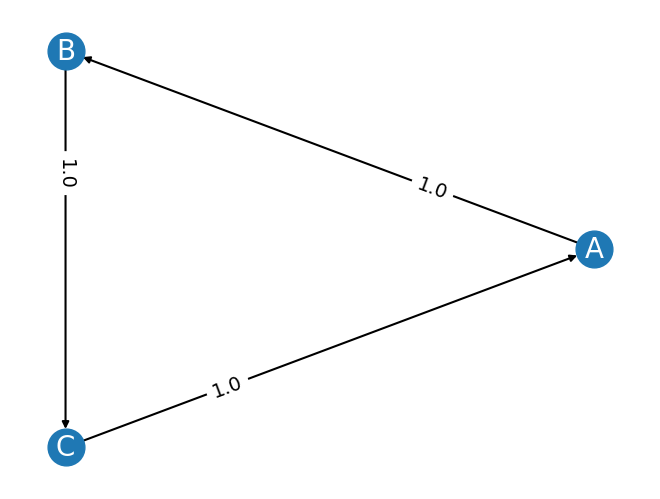

In [6]:
comparisons1 = [({"A", "B"}, {"A"}), ({"A", "C"}, {"C"}), ({"B", "C"}, {"B"})]
comparisons2 = [({"A", "B"}, {"B"}), ({"A", "C"}, {"A"}), ({"B", "C"}, {"C"})]
pprof = PairwiseProfile([PairwiseComparisons(comparisons1), PairwiseComparisons(comparisons2)], rcounts=[3,2])

pprof.display()

pprof.margin_graph().display()

In [41]:
_pcomps = [(0, 1), (2, 1), ({0, 2}, {0, 2})]
pcomps = PairwiseComparisons(_pcomps)
print(pcomps.is_coherent())
pcomps.display()
print(pcomps)
print("pcomps.weak_preference(0, 1)", pcomps.weak_preference(0, 1))
print("pcomps.weak_preference(1, 0)", pcomps.weak_preference(1, 0))
print("pcomps.strict_preference(0, 1)", pcomps.strict_preference(0, 1))
print("pcomps.strict_preference(1, 0)", pcomps.strict_preference(1, 0))
print("pcomps.indifference(0, 1)", pcomps.indifference(0, 1))   
print("pcomps.indifference(1, 0)", pcomps.indifference(1, 0))

print("pcomps.weak_preference(0, 2)", pcomps.weak_preference(0, 2))
print("pcomps.weak_preference(2, 0)", pcomps.weak_preference(2, 0))
print("pcomps.strict_preference(0, 2)", pcomps.strict_preference(0, 2))
print("pcomps.strict_preference(2, 0)", pcomps.strict_preference(2, 0))
print("pcomps.indifference(0, 2)", pcomps.indifference(0, 2))   
print("pcomps.indifference(2, 0)", pcomps.indifference(2, 0))


print("pcomps.weak_preference(3, 4)", pcomps.weak_preference(3, 4))
print("pcomps.strict_preference(3, 4)", pcomps.strict_preference(3, 4))
print("pcomps.indifference(3, 4)", pcomps.indifference(3, 4))   

print("pcomps.has_comparison(0, 1)", pcomps.has_comparison(0, 1))
print("pcomps.has_comparison(1, 0)", pcomps.has_comparison(1, 0))
print("pcomps.has_comparison(0, 2)", pcomps.has_comparison(0, 2))
print("pcomps.has_comparison(2, 0)", pcomps.has_comparison(2, 0))
print("pcomps.has_comparison(3, 4)", pcomps.has_comparison(3, 4))
print("pcomps.has_comparison(2, 4)", pcomps.has_comparison(2, 4))


True
{0, 1} -> {0}
{1, 2} -> {2}
{0, 2} -> {0, 2}
{0, 1} -> {0}, {1, 2} -> {2}, {0, 2} -> {0, 2}
pcomps.weak_preference(0, 1) True
pcomps.weak_preference(1, 0) False
pcomps.strict_preference(0, 1) True
pcomps.strict_preference(1, 0) False
pcomps.indifference(0, 1) False
pcomps.indifference(1, 0) False
pcomps.weak_preference(0, 2) True
pcomps.weak_preference(2, 0) True
pcomps.strict_preference(0, 2) False
pcomps.strict_preference(2, 0) False
pcomps.indifference(0, 2) True
pcomps.indifference(2, 0) True
pcomps.weak_preference(3, 4) False
pcomps.strict_preference(3, 4) False
pcomps.indifference(3, 4) False
pcomps.has_comparison(0, 1) True
pcomps.has_comparison(1, 0) True
pcomps.has_comparison(0, 2) True
pcomps.has_comparison(2, 0) True
pcomps.has_comparison(3, 4) False
pcomps.has_comparison(2, 4) False


3: {0, 1} -> {1}, {2, 3} -> {3}
2: {0, 2} -> {0, 2}, {0, 1} -> {1}
[0, 1, 2, 3]
[<__main__.PairwiseComparisons object at 0x28a738d10>, <__main__.PairwiseComparisons object at 0x28a738810>]
[[0. 0. 0. 0.]
 [5. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 3. 0.]]
margin(0, 0) = 0.0
margin(0, 1) = -5.0
margin(0, 2) = 0.0
margin(0, 3) = 0.0
margin(1, 0) = 5.0
margin(1, 1) = 0.0
margin(1, 2) = 0.0
margin(1, 3) = 0.0
margin(2, 0) = 0.0
margin(2, 1) = 0.0
margin(2, 2) = 0.0
margin(2, 3) = -3.0
margin(3, 0) = 0.0
margin(3, 1) = 0.0
margin(3, 2) = 3.0
margin(3, 3) = 0.0
None
None


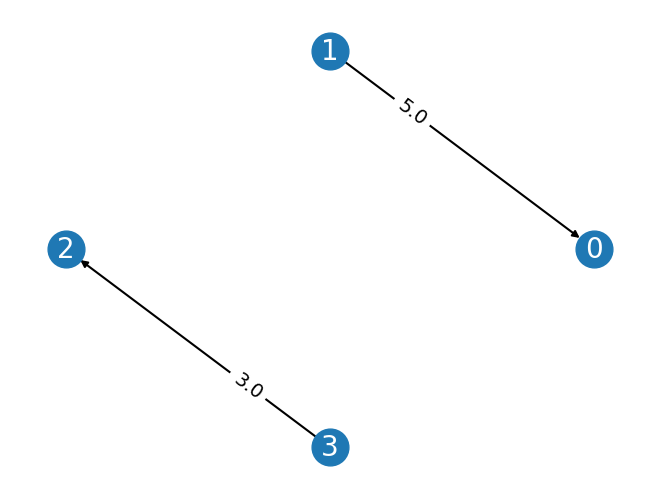

Split Cycle winners are {1, 3}


RuntimeError: did not converge

In [43]:
pprof = PairwiseProfile([
    [[{0, 1}, {1}], (3, 2)], 
    [[{0, 2}, {2, 0}], [{0, 1}, {1}]]], 
    rcounts=[3, 2])

print(pprof)

pprof.display()
print(pprof.candidates)
print(pprof._pairwise_comparisons)
print(pprof._tally)
for c in pprof.candidates:
    for d in pprof.candidates:
        print(f'margin({c}, {d}) = {pprof.margin(c,d)}') 

print(pprof.condorcet_winner())

print(pprof.condorcet_loser())  
pprof.margin_graph().display()

split_cycle.display(pprof.margin_graph())

bradley_terry.display(pprof)

Minimal election for a violation of condorcet_winner found.
minimal
+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 1 | 2 | 3 |
| 0 | 0 | 0 |
| 3 | 3 | 2 |
| 2 | 1 | 1 |
+---+---+---+


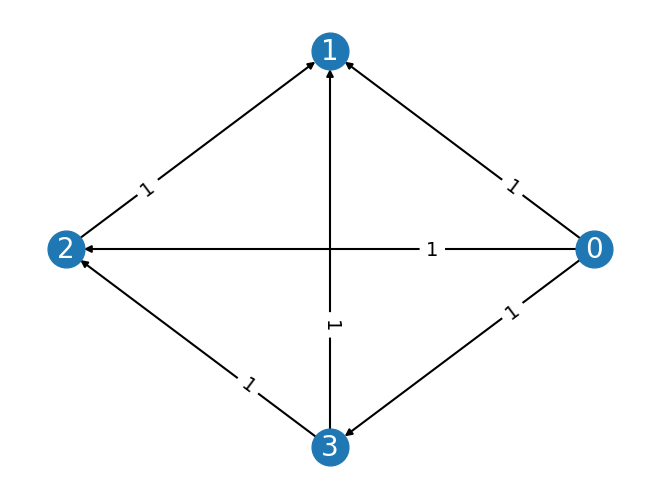

Profile([[1, 0, 3, 2], [2, 0, 3, 1], [3, 0, 2, 1]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
The Condorcet winner 0 is not the unique winner: 
Superior Voting winners are {0, 3}


In [3]:
violations = superior_voting.get_violation_witness("condorcet_winner")

for prof_type, prof in violations.items():
    if prof is not None:
        print(prof_type)
        print(prof)
        condorcet_winner.has_violation(prof, superior_voting, verbose=True)
    

In [3]:
for vm in voting_methods.filter(violates=["condorcet_winner"], election_types=[ElectionTypes.PROFILE]):
    print(vm)

Anti-Plurality
Borda
Dowdall
Plurality
Positive-Negative Voting
Coombs
Coombs PUT
Coombs TB
Instant Runoff
Instant Runoff PUT
Instant Runoff TB
Iterated Removal Condorcet Loser
PluralityWRunoff PUT
Bracket Voting
Bucklin
Pareto
Simplified Bucklin
Superior Voting
Weighted Bucklin


Anti-Plurality
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


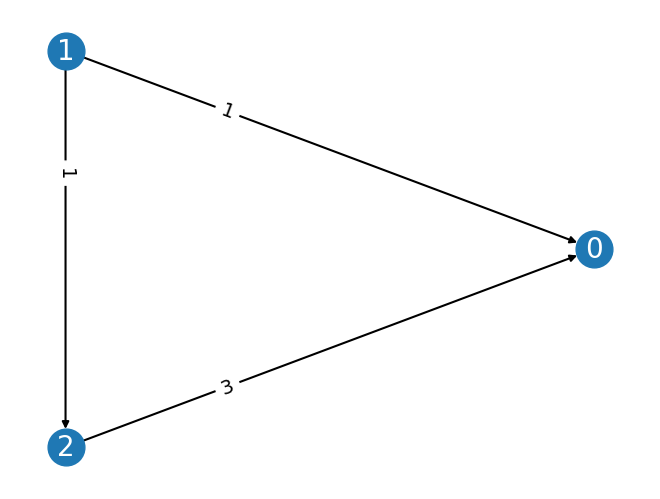

Profile([[1, 2, 0], [2, 0, 1]], rcounts=[2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 1 is not the unique winner: 
Anti-Plurality winner is {2}
minimal


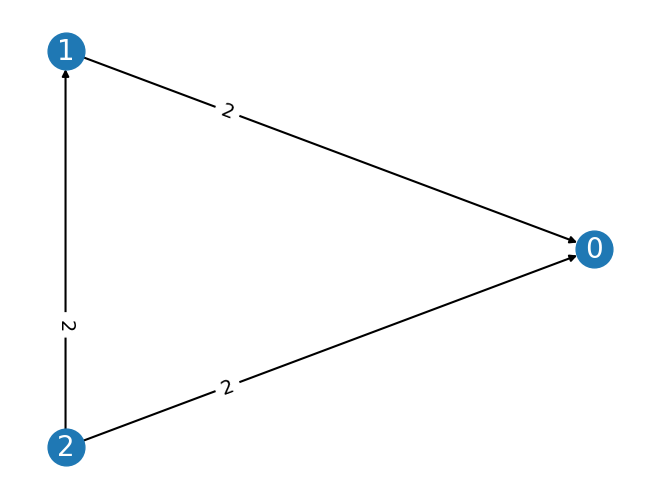

Profile([[2, 1, 0]], rcounts=[2], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Anti-Plurality winners are {1, 2}
Borda
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


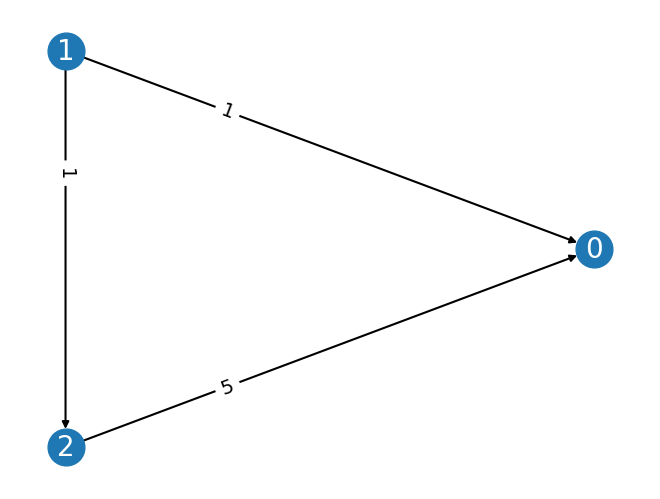

Profile([[1, 2, 0], [2, 0, 1]], rcounts=[3, 2], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 1 is not the unique winner: 
Borda winner is {2}
minimal


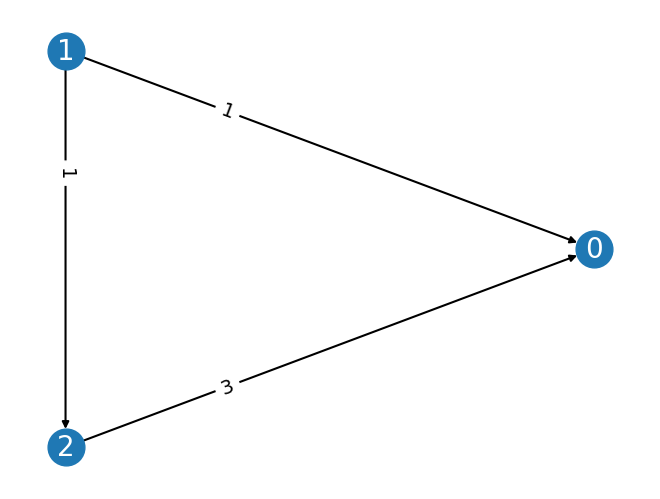

Profile([[1, 2, 0], [2, 0, 1]], rcounts=[2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 1 is not the unique winner: 
Borda winners are {1, 2}
Borda (for Truncated Profiles)
Borda (for Truncated Profiles) does not have a value for condorcet_winner, no election returned.
Dowdall
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


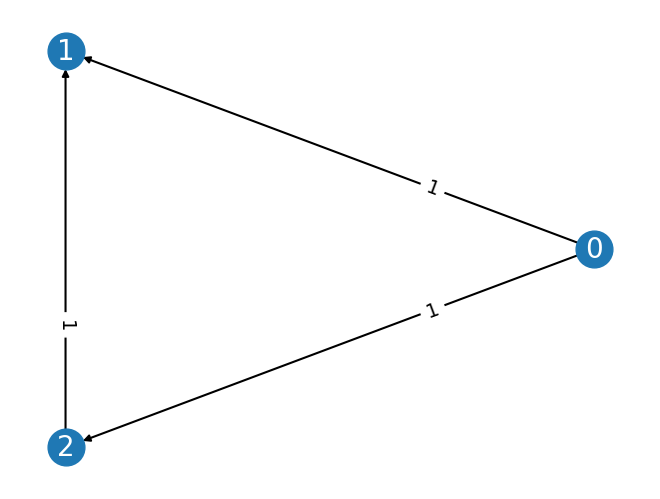

Profile([[1, 0, 2], [2, 0, 1], [0, 2, 1]], rcounts=[2, 2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Dowdall winner is {2}
minimal


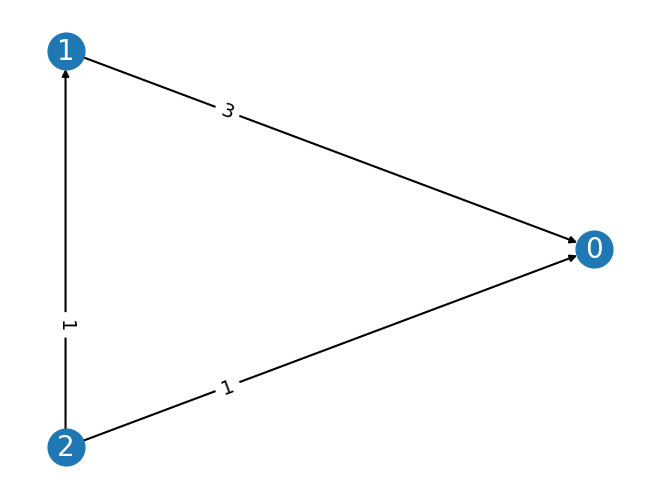

Profile([[2, 1, 0], [0, 2, 1], [1, 0, 2], [1, 2, 0]], rcounts=[2, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Dowdall winners are {1, 2}
Plurality
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


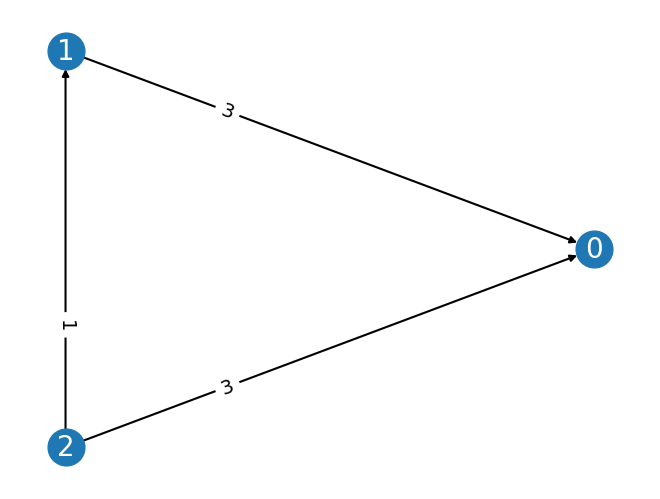

Profile([[1, 2, 0], [0, 2, 1], [2, 1, 0]], rcounts=[3, 2, 2], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Plurality winner is {1}
minimal


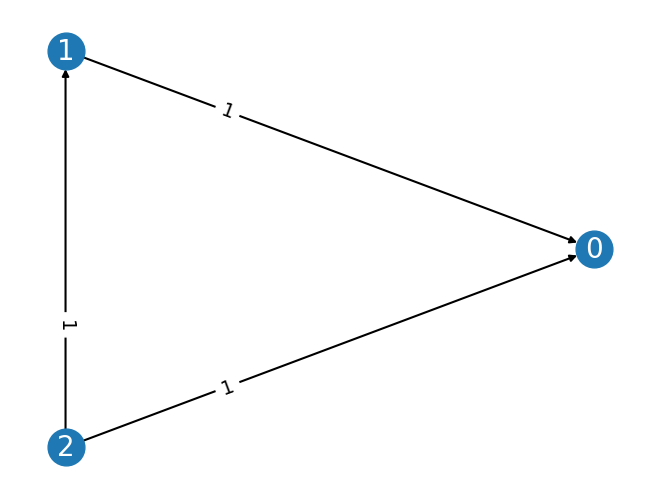

Profile([[0, 2, 1], [1, 2, 0], [2, 1, 0]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Plurality winners are {0, 1, 2}
Positive-Negative Voting
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


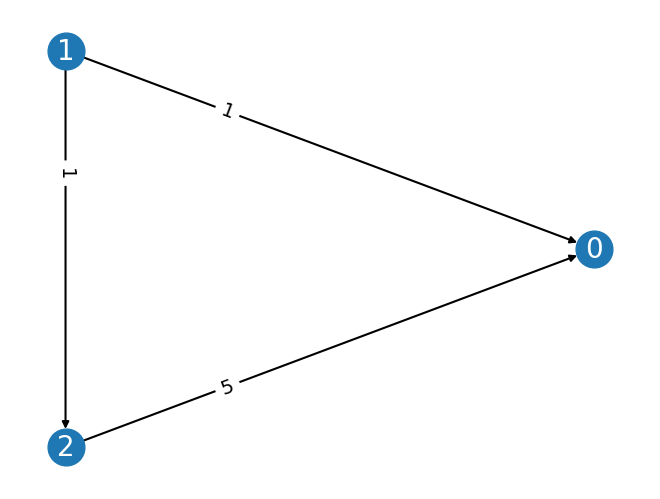

Profile([[1, 2, 0], [2, 0, 1]], rcounts=[3, 2], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 1 is not the unique winner: 
Positive-Negative Voting winner is {2}
minimal


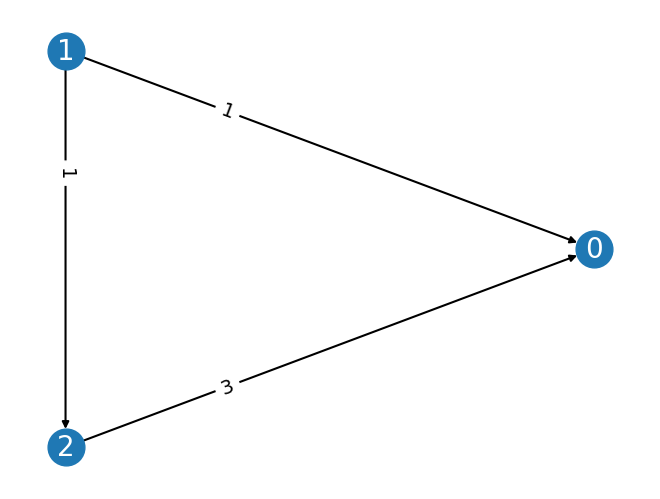

Profile([[1, 2, 0], [2, 0, 1]], rcounts=[2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 1 is not the unique winner: 
Positive-Negative Voting winners are {1, 2}
Baldwin
Baldwin satisfies condorcet_winner, no election returned.
Baldwin PUT
Baldwin PUT satisfies condorcet_winner, no election returned.
Baldwin TB
Baldwin TB satisfies condorcet_winner, no election returned.
Benham
Benham satisfies condorcet_winner, no election returned.
Benham PUT
Benham PUT satisfies condorcet_winner, no election returned.
Benham TB
Benham TB satisfies condorcet_winner, no election returned.
Bottom-Two-Runoff Instant Runoff
Bottom-Two-Runoff Instant Runoff satisfies condorcet_winner, no election returned.
Bottom-Two-Runoff Instant Runoff PUT
Bottom-Two-Runoff Instant Runoff PUT does not have a value for condorcet_winner, no election returned.
Coombs
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
Minimal resolute 

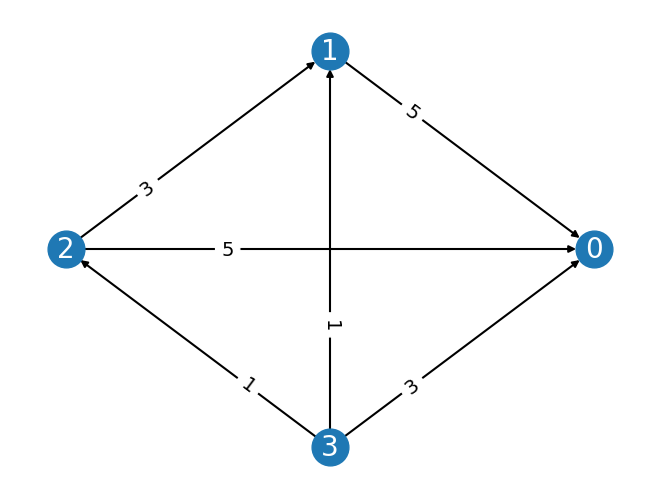

Profile([[2, 1, 0, 3], [3, 1, 0, 2], [3, 2, 0, 1], [1, 3, 2, 0], [2, 3, 1, 0]], rcounts=[3, 2, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
The Condorcet winner 3 is not the unique winner: 
Coombs winner is {2}
minimal


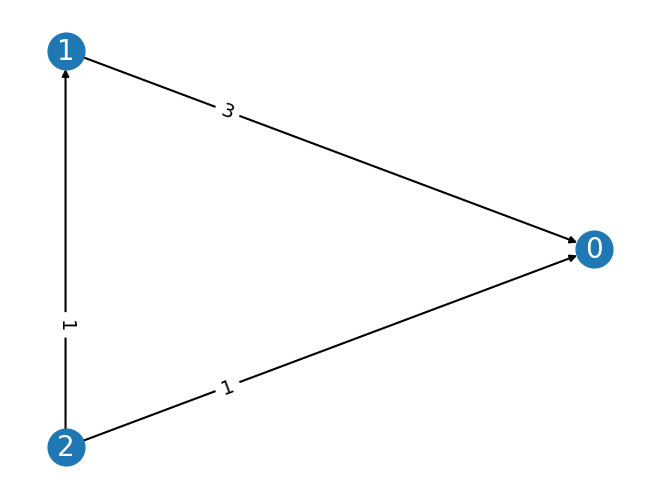

Profile([[1, 0, 2], [2, 0, 1], [2, 1, 0], [0, 2, 1], [1, 2, 0]], rcounts=[3, 2, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Coombs winners are {0, 1, 2}
Coombs PUT
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


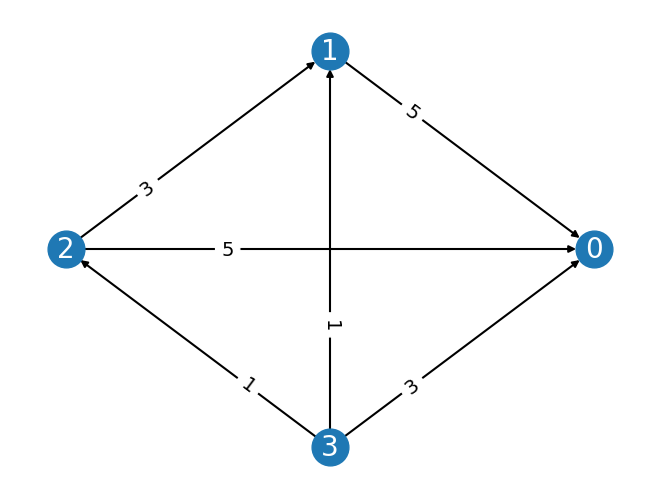

Profile([[2, 1, 0, 3], [3, 1, 0, 2], [3, 2, 0, 1], [1, 3, 2, 0], [2, 3, 1, 0]], rcounts=[3, 2, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
The Condorcet winner 3 is not the unique winner: 
Coombs PUT winner is {2}
minimal


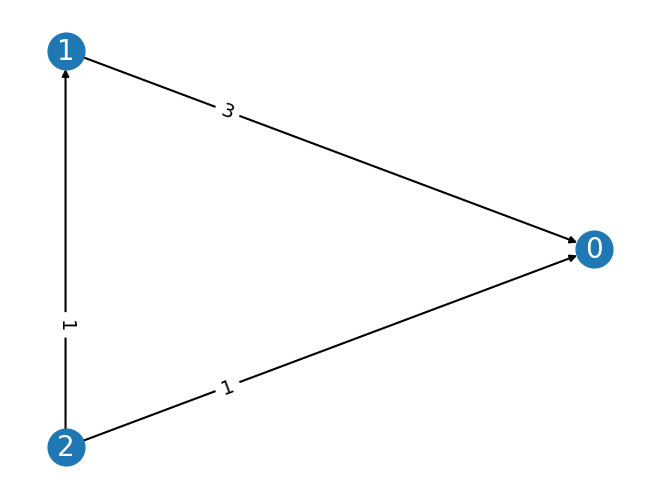

Profile([[1, 0, 2], [2, 0, 1], [2, 1, 0], [0, 2, 1], [1, 2, 0]], rcounts=[3, 2, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Coombs PUT winners are {1, 2}
Coombs TB
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


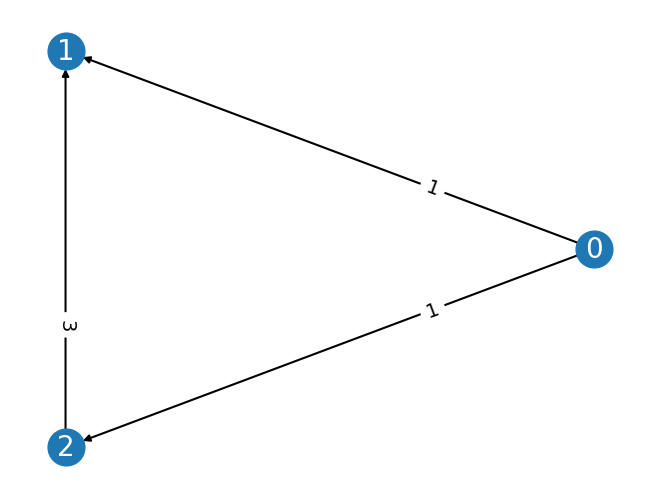

Profile([[2, 1, 0], [0, 1, 2], [0, 2, 1], [1, 0, 2], [2, 0, 1]], rcounts=[3, 2, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Coombs TB winner is {2}
minimal


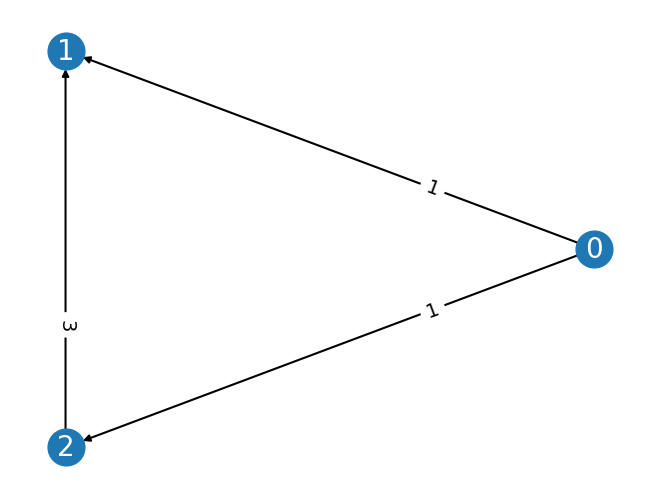

Profile([[2, 1, 0], [0, 1, 2], [0, 2, 1], [1, 0, 2], [2, 0, 1]], rcounts=[3, 2, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Coombs TB winner is {2}
GOCHA
GOCHA satisfies condorcet_winner, no election returned.
Instant Runoff
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


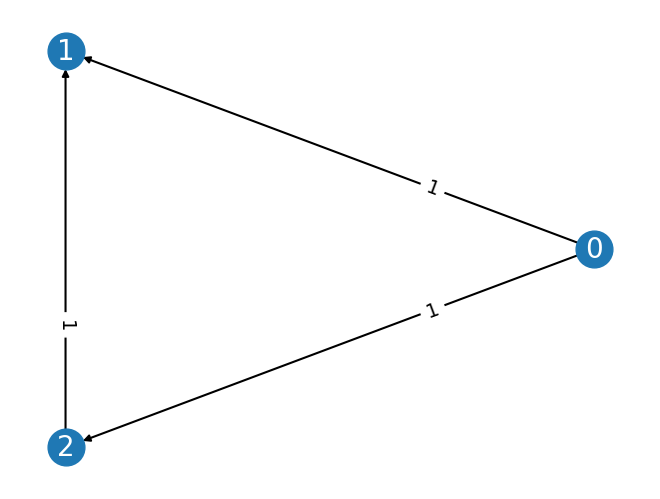

Profile([[0, 2, 1], [1, 0, 2], [2, 0, 1]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Instant Runoff winners are {0, 1, 2}
minimal


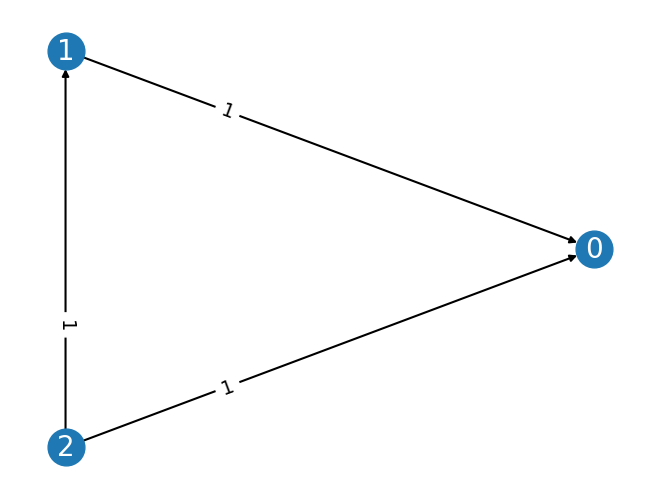

Profile([[0, 2, 1], [1, 2, 0], [2, 1, 0]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Instant Runoff winners are {0, 1, 2}
Instant Runoff (Truncated Linear Orders)
Instant Runoff (Truncated Linear Orders) does not have a value for condorcet_winner, no election returned.
Instant Runoff PUT
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


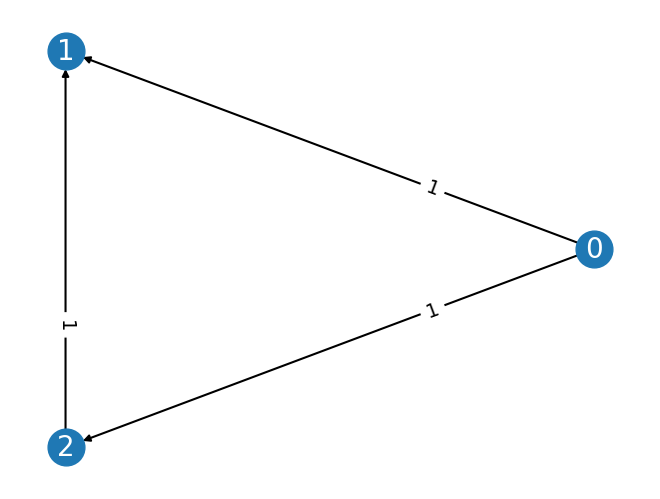

Profile([[1, 0, 2], [2, 0, 1], [0, 2, 1]], rcounts=[2, 2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Instant Runoff PUT winner is {2}
minimal


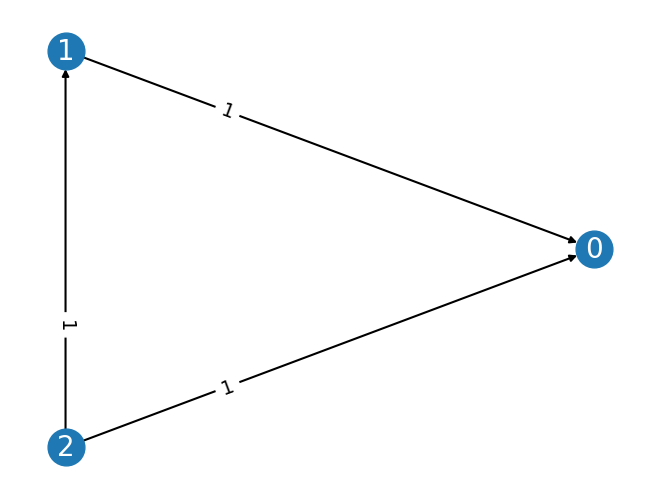

Profile([[0, 2, 1], [1, 2, 0], [2, 1, 0]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Instant Runoff PUT winners are {1, 2}
Instant Runoff TB
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


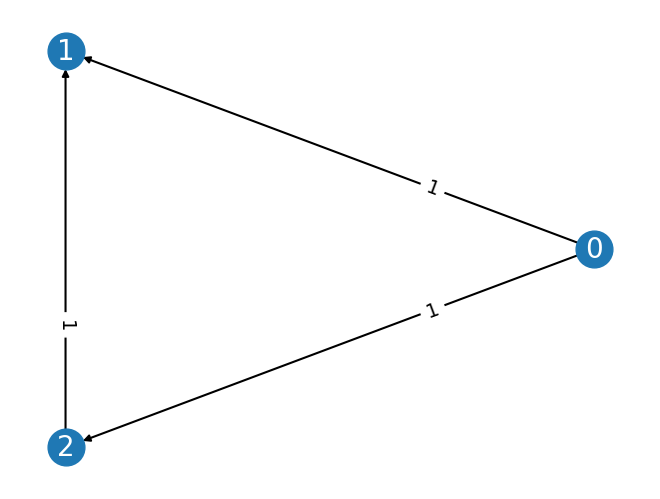

Profile([[0, 2, 1], [1, 0, 2], [2, 0, 1]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Instant Runoff TB winner is {2}
minimal


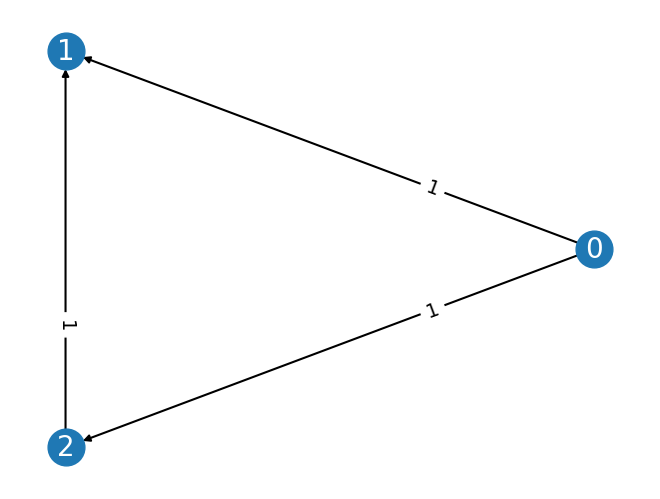

Profile([[0, 2, 1], [1, 0, 2], [2, 0, 1]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
Instant Runoff TB winner is {2}
Iterated Removal Condorcet Loser
Minimal election for a violation of condorcet_winner found.
minimal


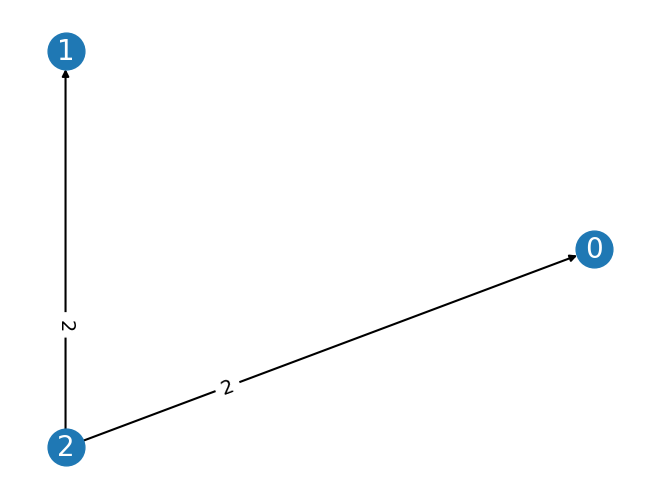

Profile([[2, 0, 1], [2, 1, 0]], rcounts=[1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Iterated Removal Condorcet Loser winners are {0, 1, 2}
Knockout Voting
Knockout Voting does not have a value for condorcet_winner, no election returned.
PluralityWRunoff PUT
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


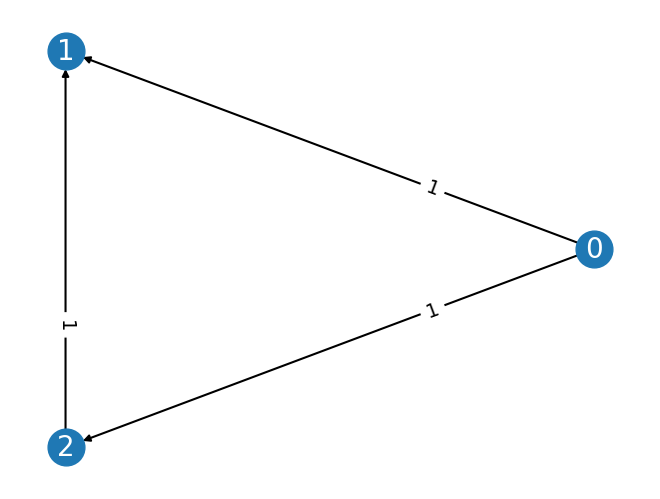

Profile([[1, 0, 2], [2, 0, 1], [0, 2, 1]], rcounts=[2, 2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 0 is not the unique winner: 
PluralityWRunoff PUT winner is {2}
minimal


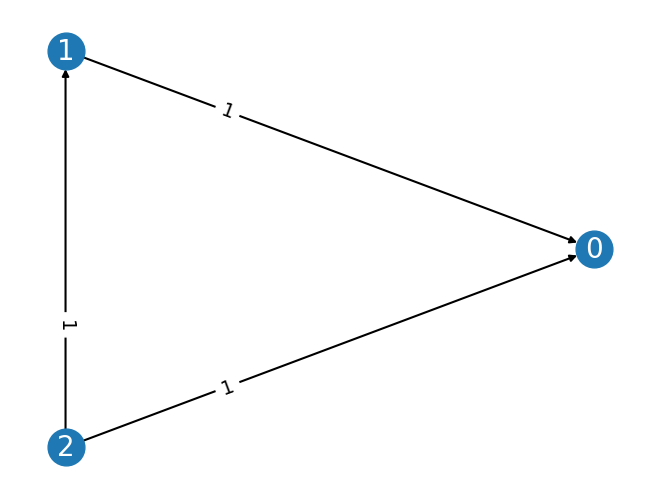

Profile([[0, 2, 1], [1, 2, 0], [2, 1, 0]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
PluralityWRunoff PUT winners are {1, 2}
Raynaud
Raynaud satisfies condorcet_winner, no election returned.
Split Cycle
Split Cycle satisfies condorcet_winner, no election returned.
Strict Nanson
Strict Nanson satisfies condorcet_winner, no election returned.
Tideman Alternative GOCHA
Tideman Alternative GOCHA satisfies condorcet_winner, no election returned.
Tideman Alternative GOCHA PUT
Tideman Alternative GOCHA PUT satisfies condorcet_winner, no election returned.
Tideman Alternative Top Cycle
Tideman Alternative Top Cycle satisfies condorcet_winner, no election returned.
Tideman Alternative Top Cycle PUT
Tideman Alternative Top Cycle PUT satisfies condorcet_winner, no election returned.
Top Cycle
Top Cycle satisfies condorcet_winner, no election returned.
Weak Nanson
Weak Nanson satisfies condorcet_winner, no election returned.
Woodall
Woodall

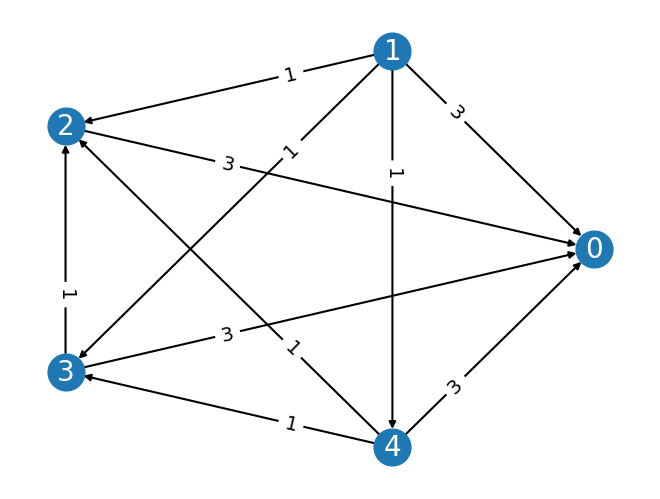

Profile([[2, 1, 4, 3, 0], [3, 1, 4, 2, 0], [4, 1, 3, 2, 0]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3', 4: '4'})
The Condorcet winner 1 is not the unique winner: 
Bracket Voting winner is {4}
Bradley-Terry
Bradley-Terry does not have a value for condorcet_winner, no election returned.
Bucklin
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


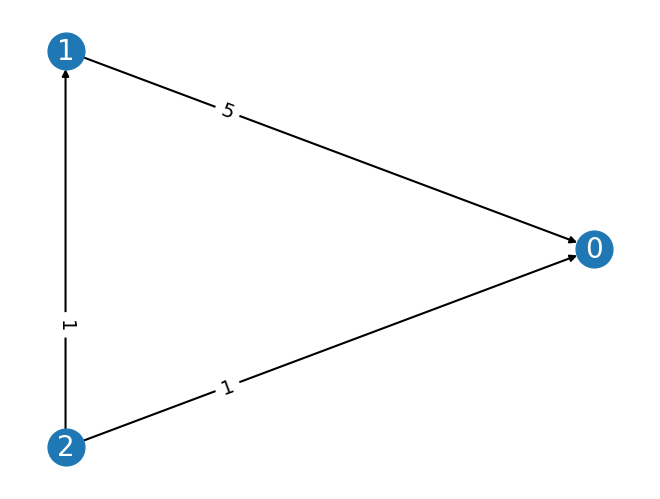

Profile([[2, 1, 0], [1, 0, 2], [0, 2, 1], [1, 2, 0]], rcounts=[3, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Bucklin winner is {1}
minimal


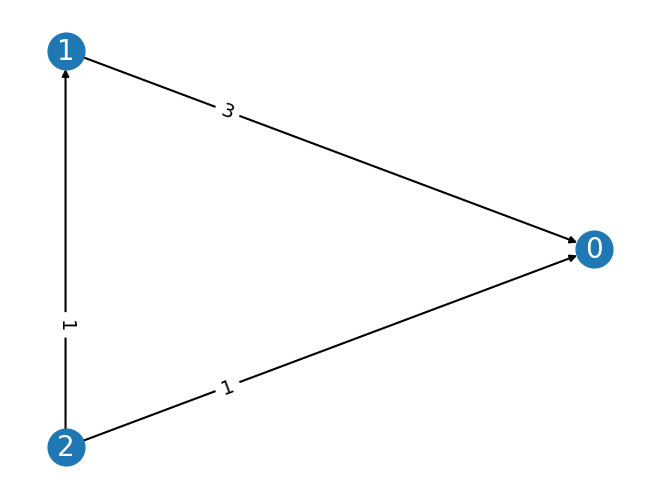

Profile([[2, 1, 0], [0, 2, 1], [1, 0, 2], [1, 2, 0]], rcounts=[2, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Bucklin winners are {1, 2}
Kemeny-Young
Kemeny-Young satisfies condorcet_winner, no election returned.
Pareto
Minimal election for a violation of condorcet_winner found.
minimal


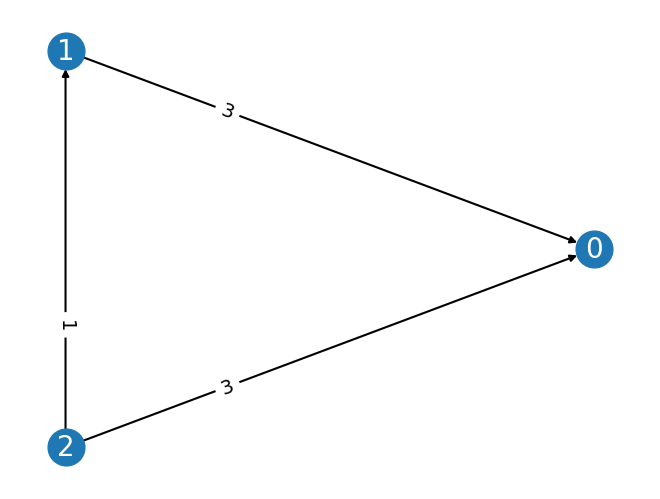

Profile([[2, 1, 0], [1, 2, 0]], rcounts=[2, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Pareto winners are {1, 2}
Preliminary Weighted Condorcet
Preliminary Weighted Condorcet satisfies condorcet_winner, no election returned.
Simplified Bucklin
Minimal election for a violation of condorcet_winner found.
Minimal resolute election for a violation of condorcet_winner found.
minimal resolute


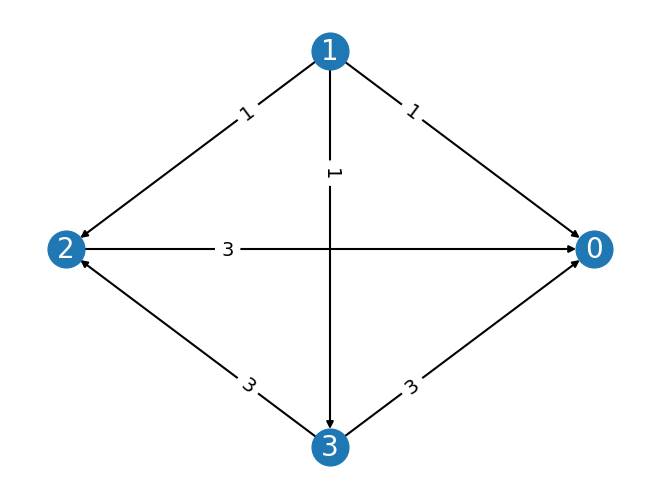

Profile([[1, 3, 2, 0], [2, 0, 1, 3], [3, 0, 1, 2], [3, 2, 1, 0]], rcounts=[2, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
The Condorcet winner 1 is not the unique winner: 
Simplified Bucklin winner is {3}
minimal


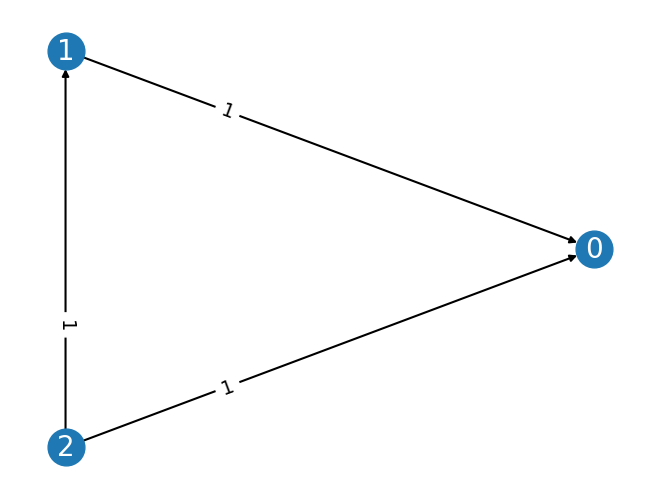

Profile([[0, 2, 1], [1, 2, 0], [2, 1, 0]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Simplified Bucklin winners are {1, 2}
Superior Voting
Minimal election for a violation of condorcet_winner found.
minimal


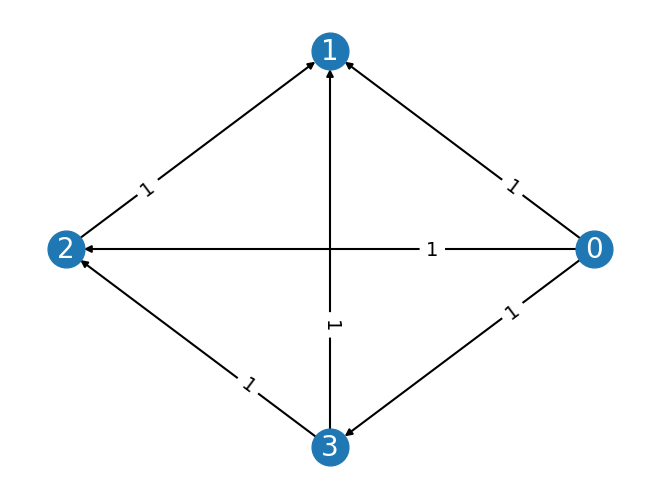

Profile([[1, 0, 3, 2], [2, 0, 3, 1], [3, 0, 2, 1]], rcounts=[1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
The Condorcet winner 0 is not the unique winner: 
Superior Voting winners are {0, 3}
Weighted Bucklin
Minimal resolute election for a violation of condorcet_winner found.
Minimal election for a violation of condorcet_winner found.
minimal resolute


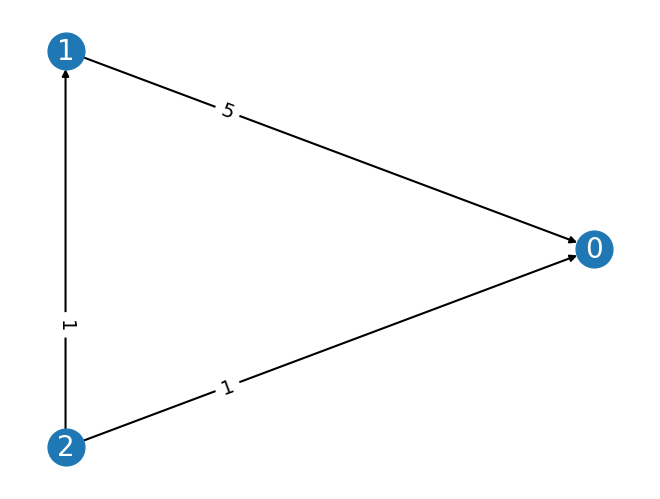

Profile([[2, 1, 0], [1, 0, 2], [0, 2, 1], [1, 2, 0]], rcounts=[3, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Weighted Bucklin winner is {1}
minimal


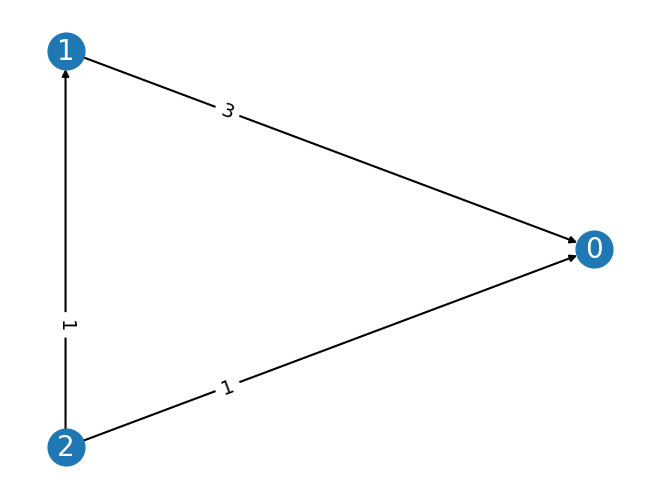

Profile([[2, 1, 0], [0, 2, 1], [1, 0, 2], [1, 2, 0]], rcounts=[2, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2'})
The Condorcet winner 2 is not the unique winner: 
Weighted Bucklin winners are {1, 2}


In [4]:
for vm in voting_methods: 
    print(vm)
    elections = vm.get_violation_witness("condorcet_winner")
    for prof_type, prof in elections.items():
        if prof is not None:
            print(prof_type)
            condorcet_winner.has_violation(prof, vm, verbose=True)

In [9]:
for vm in voting_methods:
    print(vm.__name__)
    print(vm.name)
    print(vm.properties.items())
    print(vm.get_properties())
    print

anti_plurality
Anti-Plurality
dict_items([('condorcet_loser', False), ('condorcet_winner', False), ('pareto_dominance', False), ('positive_involvement', True)])
{'satisfied': ['positive_involvement'], 'violated': ['condorcet_loser', 'condorcet_winner', 'pareto_dominance'], 'na': []}
borda
Borda
dict_items([('condorcet_loser', True), ('condorcet_winner', False), ('pareto_dominance', True), ('positive_involvement', True)])
{'satisfied': ['condorcet_loser', 'pareto_dominance', 'positive_involvement'], 'violated': ['condorcet_winner'], 'na': []}
borda_for_profile_with_ties
Borda (for Truncated Profiles)
dict_items([('condorcet_loser', None), ('condorcet_winner', None), ('pareto_dominance', None)])
{'satisfied': [], 'violated': [], 'na': ['condorcet_loser', 'condorcet_winner', 'pareto_dominance']}
dowdall
Dowdall
dict_items([('condorcet_loser', False), ('condorcet_winner', False), ('pareto_dominance', True), ('positive_involvement', True)])
{'satisfied': ['pareto_dominance', 'positive_invol

In [10]:
print(axioms_dict)

{'pareto_dominance': <pref_voting.axiom.Axiom object at 0x1471fc290>, 'condorcet_winner': <pref_voting.axiom.Axiom object at 0x1074162d0>, 'condorcet_loser': <pref_voting.axiom.Axiom object at 0x2955cf590>, 'smith': <pref_voting.axiom.Axiom object at 0x2955ce390>, 'schwartz': <pref_voting.axiom.Axiom object at 0x2955ce0d0>, 'monotonicity': <pref_voting.axiom.Axiom object at 0x2c0421010>, 'weak_positive_responsiveness': <pref_voting.axiom.Axiom object at 0x2c0421090>, 'homogeneity': <pref_voting.axiom.Axiom object at 0x2c0420fd0>, 'upward_homogeneity': <pref_voting.axiom.Axiom object at 0x2c04213d0>, 'downward_homogeneity': <pref_voting.axiom.Axiom object at 0x2c0421610>, 'block_invariance': <pref_voting.axiom.Axiom object at 0x2c0421790>, 'upward_block_preservation': <pref_voting.axiom.Axiom object at 0x2c0421850>, 'downward_block_preservation': <pref_voting.axiom.Axiom object at 0x2c0421910>, 'strategy_proofness': <pref_voting.axiom.Axiom object at 0x2c0421b90>, 'reinforcement': <pref

In [11]:
prof = generate_profile(5, 10)
prof.display()

print(prof.margin(0, 4))

pickle.dump(prof, open("profile.pkl", "wb"))
prof = pickle.load(open("profile.pkl", "rb"))
prof.display()

print(prof.margin(0, 4))


for vm in voting_methods:
    print(vm.name)
    if ElectionTypes.PROFILE in vm.input_types:
        print(vm(prof))


+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 3 | 2 | 2 | 3 | 4 | 4 | 0 | 3 | 2 | 4 |
| 2 | 1 | 1 | 2 | 3 | 3 | 2 | 1 | 3 | 1 |
| 1 | 4 | 3 | 1 | 1 | 1 | 1 | 2 | 1 | 3 |
| 4 | 3 | 0 | 4 | 0 | 2 | 3 | 0 | 4 | 0 |
| 0 | 0 | 4 | 0 | 2 | 0 | 4 | 4 | 0 | 2 |
+---+---+---+---+---+---+---+---+---+---+
-4
+---+---+---+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+---+---+---+
| 3 | 2 | 2 | 3 | 4 | 4 | 0 | 3 | 2 | 4 |
| 2 | 1 | 1 | 2 | 3 | 3 | 2 | 1 | 3 | 1 |
| 1 | 4 | 3 | 1 | 1 | 1 | 1 | 2 | 1 | 3 |
| 4 | 3 | 0 | 4 | 0 | 2 | 3 | 0 | 4 | 0 |
| 0 | 0 | 4 | 0 | 2 | 0 | 4 | 4 | 0 | 2 |
+---+---+---+---+---+---+---+---+---+---+
-4
Anti-Plurality
[1, 3]
Borda
[3]
Borda (for Truncated Profiles)
Dowdall
[3]
Plurality
[2, 3, 4]
Positive-Negative Voting
[3]
Baldwin


In [ ]:
r = [2, 0, 5, 4, 3, 1]
u = Utility.from_linear_ranking(r, seed=42)
print(u)
u.ranking().to_linear()


U(2) = 0.9756223516367559, U(0) = 0.8585979199113825, U(5) = 0.7739560485559633, U(4) = 0.6973680290593639, U(3) = 0.4388784397520523, U(1) = 0.09417734788764953


(2, 0, 5, 4, 3, 1)

In [ ]:
prof = generate_profile(3, 2, seed=42)

prof.display()

uprof = prof.to_utility_profile()

uprof.display()

uprof.to_ranking_profile().to_linear_profile().display()


+---+---+
| 1 | 1 |
+---+---+
| 2 | 0 |
| 1 | 2 |
| 0 | 1 |
+---+---+
  Voter          0          1         2
-------  ---------  ---------  --------
      1  0.0431592  0.127971   0.555224
      2  0.763745   0.0953413  0.130938
+---+---+
| 1 | 1 |
+---+---+
| 2 | 0 |
| 1 | 2 |
| 0 | 1 |
+---+---+


In [ ]:
rng = np.random.default_rng(42)
        
utilities = sorted(rng.random(size=6), reverse=True)
print(utilities)


[0.9756223516367559, 0.8585979199113825, 0.7739560485559633, 0.6973680290593639, 0.4388784397520523, 0.09417734788764953]


In [ ]:
prof = ProfileWithTies([
    {'a': 1, 'b': 2, 'c': 3},
    {'a': 2, 'b': 1, 'c': 3},
    {'a': 3, 'b': 2, 'c': 1},
    {'a': 3},
    {'a': 2, 'b': 3, 'c': 1},
    {'a': 1, 'b': 3},
])

prof.display()

split_cycle.display(prof)
split_cycle.display(prof, algorithm='basic_parallel')

split_cycle.display(prof, curr_cands = ['b', 'c'])

split_cycle.display(prof, algorithm='basic_parallel', curr_cands = ['b', 'c'])

+---+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+
| a | b | c | a | c | a |
| b | a | b |   | a | b |
| c | c | a |   | b |   |
+---+---+---+---+---+---+
Split Cycle winners are {a, c}
Split Cycle winners are {a, c}
Split Cycle winners are {b, c}
Split Cycle winners are {b, c}


In [ ]:

for t in tqdm(range(1000)): 

    prof = generate_profile(random.choice([4, 5, 10, 15]),random.choice([5, 10, 100, 1001]))
    sc_ws = split_cycle(prof)
    sc_ws_parallel = split_cycle(prof, algorithm='basic_parallel')

    if sc_ws != sc_ws_parallel:
        print(prof)
        print(sc_ws)
        print(sc_ws_parallel)
        print("Error")
        break

    sc_ws = split_cycle(prof, curr_cands = [1, 2, 3])
    sc_ws_parallel = split_cycle(prof, curr_cands = [1, 2, 3], algorithm='basic_parallel')

    if sc_ws != sc_ws_parallel:
        print(prof)
        print(sc_ws)
        print(sc_ws_parallel)
        print("Error")
        break



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
profs = [generate_edge_ordered_tournament(500) for _ in range(5)]

In [ ]:
%%time

print(len([split_cycle(mg) for mg in profs]))

In [ ]:
%%time

print(len([split_cycle(mg, algorithm='basic_parallel', num_cpus=8) for mg in profs]))

In [ ]:
%time

print(len([split_cycle(prof, algorithm='floyd_warshall') for prof in profs]))

In [ ]:
split_cycle.set_algorithm("floyd_warshall")


In [ ]:
print("Total number of voting methods ", len(list(voting_methods)))

print("Total number of voting methods accepting Profile ", len(voting_methods.filter(election_types=[ElectionTypes.PROFILE])))

print("Total number of Condorcet Consistent voting methods ", len(voting_methods.filter(satisfies=["condorcet_winner"])))

print("Total number of voting methods satisfying condorcet_winner and condorcet_loser", len(voting_methods.filter(satisfies=["condorcet_winner", "condorcet_loser"])))

print("Total number of voting methods satisfying pareto_dominance", len(voting_methods.filter(satisfies=["pareto_dominance"])))

Total number of voting methods  78
Total number of voting methods accepting Profile  76
Total number of Condorcet Consistent voting methods  45
Total number of voting methods satisfying condorcet_winner and condorcet_loser 37
Total number of voting methods satisfying pareto_dominance 61


In [ ]:
# get the function name of the voting method
#print(voting_methods.get("borda").name)
# not the name parameter but rather the name of the function
print(borda.vm.__name__)

borda


In [ ]:
for vm in voting_methods: 
    print(vm.name)
    print(voting_methods.method_type(vm.name))    
    print(voting_methods.file_location(vm.name))

    filename = voting_methods.file_location(vm.name).split(".")[0]
    print(f"https://pref-voting.readthedocs.io/en/latest/{filename}.html#pref_voting.{filename}.{vm.vm.__name__}")
    #scoring_methods.html#pref_voting.scoring_methods.scoring_rule

Anti-Plurality
Scoring Rule
scoring_methods.py
https://pref-voting.readthedocs.io/en/latest/scoring_methods.html#pref_voting.scoring_methods.anti_plurality
Borda
Combined Method
combined_methods.py
https://pref-voting.readthedocs.io/en/latest/combined_methods.html#pref_voting.combined_methods.borda
Borda (for Truncated Profiles)
Scoring Rule
scoring_methods.py
https://pref-voting.readthedocs.io/en/latest/scoring_methods.html#pref_voting.scoring_methods.borda_for_profile_with_ties
Dowdall
Scoring Rule
scoring_methods.py
https://pref-voting.readthedocs.io/en/latest/scoring_methods.html#pref_voting.scoring_methods.dowdall
Plurality
Other Method
other_methods.py
https://pref-voting.readthedocs.io/en/latest/other_methods.html#pref_voting.other_methods.plurality
Positive-Negative Voting
Scoring Rule
scoring_methods.py
https://pref-voting.readthedocs.io/en/latest/scoring_methods.html#pref_voting.scoring_methods.positive_negative_voting
Baldwin
Iterative Method
iterative_methods.py
https://pre

In [ ]:
print("Total number of voting methods ", len(voting_methods))

print("Total number of voting methods accepting TruncatedLinearOrders ", len(voting_methods.filter(election_types=[ElectionTypes.TRUNCATED_LINEAR_PROFILE])))

print("Total number of voting methods accepting MarginGraph ", len(voting_methods.filter(election_types=[ElectionTypes.MARGIN_GRAPH])))

print("Total number of voting methods accepting MajorityGraph ", len(voting_methods.filter(election_types=[ElectionTypes.MAJORITY_GRAPH])))



Total number of voting methods  78
Total number of voting methods accepting TruncatedLinearOrders  3
Total number of voting methods accepting MarginGraph  30
Total number of voting methods accepting MajorityGraph  13


In [ ]:
voting_methods.display_methods()

Anti-Plurality (Scoring Rule)
Satisfied properties: ['positive_involvement']
Violated properties: ['condorcet_loser', 'condorcet_winner', 'pareto_dominance']

Borda (Combined Method)
Satisfied properties: ['condorcet_loser', 'pareto_dominance', 'positive_involvement']
Violated properties: ['condorcet_winner']

Borda (for Truncated Profiles) (Scoring Rule)
Satisfied properties: []
Violated properties: []

Dowdall (Scoring Rule)
Satisfied properties: ['pareto_dominance', 'positive_involvement']
Violated properties: ['condorcet_loser', 'condorcet_winner']

Plurality (Other Method)
Satisfied properties: ['pareto_dominance', 'positive_involvement']
Violated properties: ['condorcet_loser', 'condorcet_winner']

Positive-Negative Voting (Scoring Rule)
Satisfied properties: ['positive_involvement']
Violated properties: ['condorcet_loser', 'condorcet_winner', 'pareto_dominance']

Baldwin (Iterative Method)
Satisfied properties: ['condorcet_loser', 'condorcet_winner', 'pareto_dominance']
Violated

In [ ]:
prof = generate_profile(4, 5)
for vm in voting_methods:
    print(vm)
    if ElectionTypes.PROFILE in vm.input_types:
        vm.display(prof)

Anti-Plurality
Anti-Plurality winners are {2, 3}
Borda
Borda winner is {3}
Borda (for Truncated Profiles)
Dowdall
Dowdall winner is {3}
Plurality
Plurality winners are {0, 3}
Positive-Negative Voting
Positive-Negative Voting winner is {3}
Baldwin
Baldwin winner is {3}
Baldwin PUT
Baldwin PUT winner is {3}
Baldwin TB
Baldwin TB winner is {3}
Benham
Benham winner is {3}
Benham PUT
Benham PUT winner is {3}
Benham TB
Benham TB winner is {3}
Bottom-Two-Runoff Instant Runoff
Bottom-Two-Runoff Instant Runoff winner is {3}
Bottom-Two-Runoff Instant Runoff PUT
Bottom-Two-Runoff Instant Runoff PUT winner is {3}
Coombs
Coombs winner is {3}
Coombs PUT
Coombs PUT winner is {3}
Coombs TB
Coombs TB winner is {3}
GOCHA
GOCHA winner is {3}
Hare PUT
Hare PUT winner is {3}
Instant Runoff
Instant Runoff PUT
Instant Runoff PUT winner is {3}
Instant Runoff TB
Instant Runoff TB winner is {3}
Iterated Removal Condorcet Loser
Iterated Removal Condorcet Loser winner is {3}
Knockout Voting
Knockout Voting winner

In [ ]:
for vmidx,vm in enumerate(voting_methods): 
    print(f"{vmidx+1}. {vm}")
    vm.save_properties()

1. Anti-Plurality
2. Borda
3. Borda (for Truncated Profiles)
4. Dowdall
5. Plurality
6. Positive-Negative Voting
7. Baldwin
8. Baldwin PUT
9. Baldwin TB
10. Benham
11. Benham PUT
12. Benham TB
13. Bottom-Two-Runoff Instant Runoff
14. Bottom-Two-Runoff Instant Runoff PUT
15. Coombs
16. Coombs PUT
17. Coombs TB
18. GOCHA
19. Hare PUT
20. Instant Runoff
21. Instant Runoff PUT
22. Instant Runoff TB
23. Iterated Removal Condorcet Loser
24. Knockout Voting
25. PluralityWRunoff PUT
26. Ranked Choice PUT
27. Raynaud
28. Split Cycle
29. Strict Nanson
30. Tideman Alternative GOCHA
31. Tideman Alternative GOCHA PUT
32. Tideman Alternative Top Cycle
33. Tideman Alternative Top Cycle PUT
34. Top Cycle
35. Weak Nanson
36. Woodall
37. Banks
38. Bipartisan Set
39. Condorcet
40. Copeland
41. Llull
42. Slater
43. Uncovered Set - Bordes
44. Uncovered Set - Fishburn
45. Uncovered Set
46. Uncovered Set - McKelvey
47. Simple Stable Voting
48. Beat Path
49. Essential Set
50. Loss-Trimmer Voting
51. Minimax
5

In [ ]:

for t in range(10000): 
    prof = generate_profile(10, 100)
    if pareto_dominance.has_violation(prof,superior_voting, verbose=True): 
        print(prof)
        break


In [ ]:
from pref_voting.swf_axioms import *

In [ ]:
R=0
D=1
P=2
prof = Profile([
    [R, D, P],
    [P, D, R],
    [D, P, R]
], 
[40, 35, 25],
)

prof.display()

plurality.display(prof)
instant_runoff.display(prof)
split_cycle.display(prof)

sc_ranking = swf_from_vm(split_cycle)

@swf("DPR")
def dpr(profile, curr_cands=None):
    return Ranking({D: 1, P: 2, R: 3})
@swf("DRP")
def drp(profile, curr_cands=None):
    return Ranking({D: 1, P: 3, R: 2})
@swf("RPD")
def rpd(profile, curr_cands=None):
    return Ranking({D: 3, P: 2, R: 1})
@swf("RDP")
def rdp(profile, curr_cands=None):
    return Ranking({D: 2, P: 3, R: 1})
@swf("PDR")
def pdr(profile, curr_cands=None):
    return Ranking({D: 2, P: 1, R: 3})
@swf("PRD")
def prd(profile, curr_cands=None):
    return Ranking({D: 3, P: 1, R: 2})


In [ ]:
instant_runoff_ranking.display(prof)

irv_swf2 = swf_from_vm(instant_runoff)
irv_swf2.display(prof)

In [ ]:
core_support.find_all_violations(prof.anonymize(),pdr, verbose=True)

In [ ]:
core_support.has_violation(prof.anonymize(),drp, verbose=True)

In [10]:
borda.get_properties()

borda.add_property("condorcet_winner", False)
borda.save_properties()